In [1]:
import os
import json
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import numpy as np
import pickle
import pandas as pd
import torch
import torch.nn.functional as F
import re
import optuna

/home/thomasdev/anaconda3/envs/ultralytics-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # Catch errors immediately

import torch
torch.cuda.empty_cache()

In [4]:
from modules import (
    get_data_from_trajectory_id,
    create_simple_dataloader,
    Step_1,
    Step_2,
    CombinedHamiltonianLayer,
    SimpleStackedHamiltonianNetwork,
    ReverseStep2,
    ReverseStep1,
    ReverseCombinedHamiltonianLayer,
    InverseStackedHamiltonianNetwork,
    prediction_loss,
    prediction_loss_euclidean,
    load_checkpoint,
    count_parameters,
    hsic_loss_statistics_only,
    hsic_loss
    )

In [5]:
from modules import (    
    calculate_phi_A,
    add_phi_A_columns,
    plot_differencies,
    plot_prediction_vs_ground_truth,
    plot_distance_over_time,
    ensemble_autoregressive_prediction_gaussian_mixture_simple,
    test_model_in_single_trajectory,
    analyze_means_with_constants,
    visualize_trajectory_movements_with_std_ellipses,
    visualize_epoch_metrics,
    analyze_folders_means,
    analyze_mapping_net,
    test_model_in_all_trajectories_in_df,
    test_model_variance_in_all_trajectories_in_df,
    plot_prediction_losses,
    plot_variance_losses,
    test_model_with_varying_observed_points,
    test_model_variance_with_varying_observed_points,
    compute_jacobian_functional,
    compute_symplectic_product,
    check_canonical_transformation,
    test_canonical_tranformation_on_trajectory,
    test_model_in_all_trajectories_with_different_single_observation_in_df,
    )

In [6]:
save_dir_path = "./save_directory_noisy_full_pred_low_samples_3" 


In [7]:
with open("all_dataframes_low_samples.pkl", "rb") as f:
    loaded_dfs_low_samples = pickle.load(f)

# Access them like before:
train_df_low_samples = loaded_dfs_low_samples['train_df_low_samples']
val_df_low_samples = loaded_dfs_low_samples['val_df_low_samples']
test_df_low_samples = loaded_dfs_low_samples['test_df_low_samples']

train_id_df_low_samples = loaded_dfs_low_samples['train_id_df_low_samples']
val_id_df_low_samples = loaded_dfs_low_samples['val_id_df_low_samples']
test_id_df_low_samples = loaded_dfs_low_samples['test_id_df_low_samples']

with open("df_high_energy_low_samples.pkl", "rb") as f:
    df_high_energy_low_samples = pickle.load(f)

val_df_high_energy_low_samples = df_high_energy_low_samples['val_df_high_energy_low_samples']
val_id_df_high_energy_low_samples = df_high_energy_low_samples['val_id_df_high_energy_low_samples']

test_df_high_energy_low_samples = df_high_energy_low_samples['test_df_high_energy_low_samples']
test_id_df_high_energy_low_samples = df_high_energy_low_samples['test_id_df_high_energy_low_samples']

with open("all_dataframes_low_samples_multiple_periods.pkl", "rb") as f:
    df_low_samples_multiple_periods = pickle.load(f)

test_df_low_samples_multiple_periods = df_low_samples_multiple_periods['data_df_low_samples_multiple_periods']
test_id_df_low_samples_multiple_periods = df_low_samples_multiple_periods['id_df_low_samples_multiple_periods']

In [8]:
train_id_df_low_samples_added = add_phi_A_columns(train_id_df_low_samples)
val_id_df_low_samples_added = add_phi_A_columns(val_id_df_low_samples)
val_id_df_high_energy_low_samples_added = add_phi_A_columns(val_id_df_high_energy_low_samples)



📊 Metric summaries:
  Lowest loss of metric 'val_prediction_loss_' recorded in epoch 976 with the value: 0.0250, the losses of the last 5 epochs are: ['0.0258', '0.0260', '0.0268', '0.0270', '0.0262']
  Lowest loss of metric 'val_variance_loss_high_energy' recorded in epoch 924 with the value: 0.0144, the losses of the last 5 epochs are: ['0.0154', '0.0154', '0.0154', '0.0156', '0.0155']
  Lowest loss of metric 'val_prediction_loss_high_energy' recorded in epoch 924 with the value: 0.0940, the losses of the last 5 epochs are: ['0.0973', '0.0976', '0.0980', '0.0988', '0.0980']
  Lowest loss of metric 'val_variance_loss_training_set' recorded in epoch 976 with the value: 0.0004, the losses of the last 5 epochs are: ['0.0004', '0.0004', '0.0004', '0.0004', '0.0004']
  Lowest loss of metric 'val_prediction_loss_training_set' recorded in epoch 977 with the value: 0.0203, the losses of the last 5 epochs are: ['0.0207', '0.0207', '0.0213', '0.0216', '0.0209']
  Lowest loss of metric 'val_var

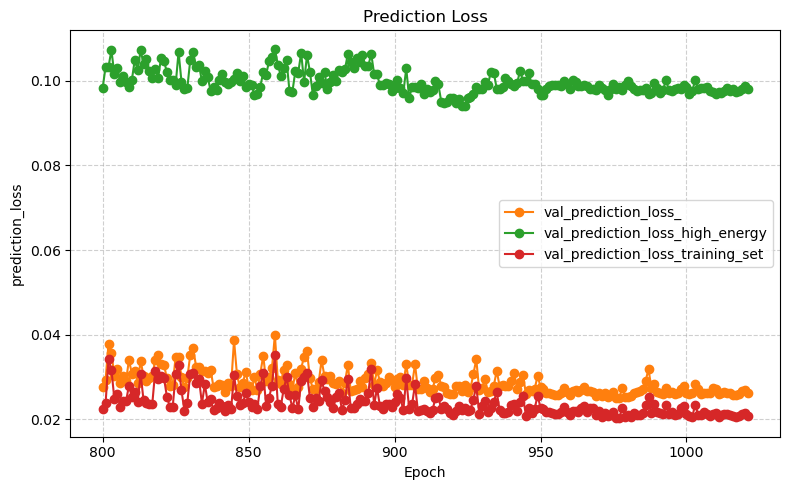

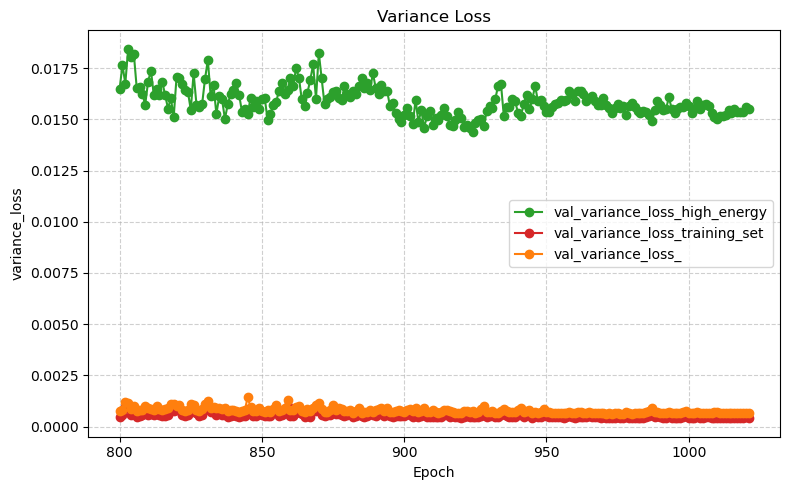

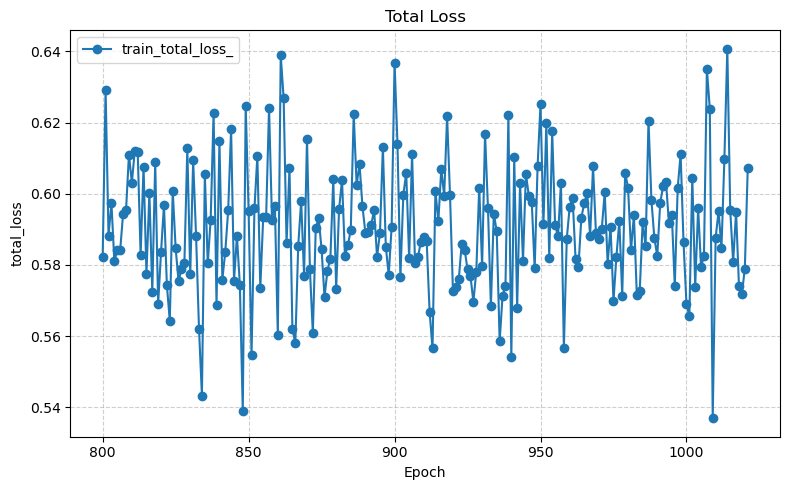

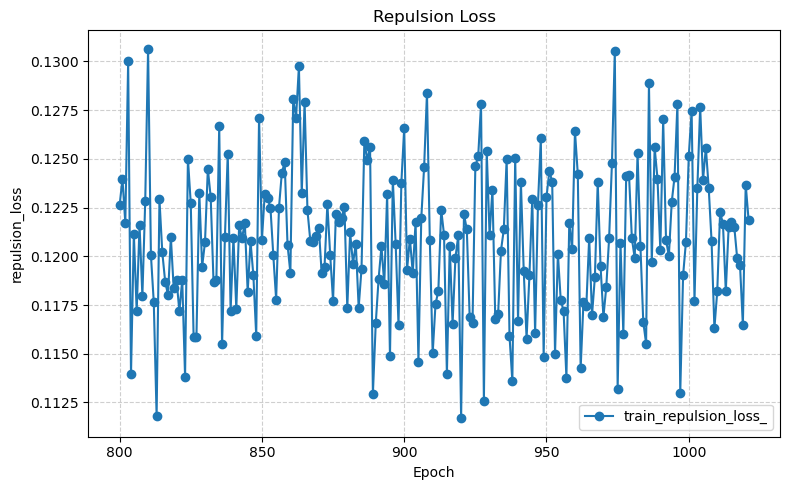

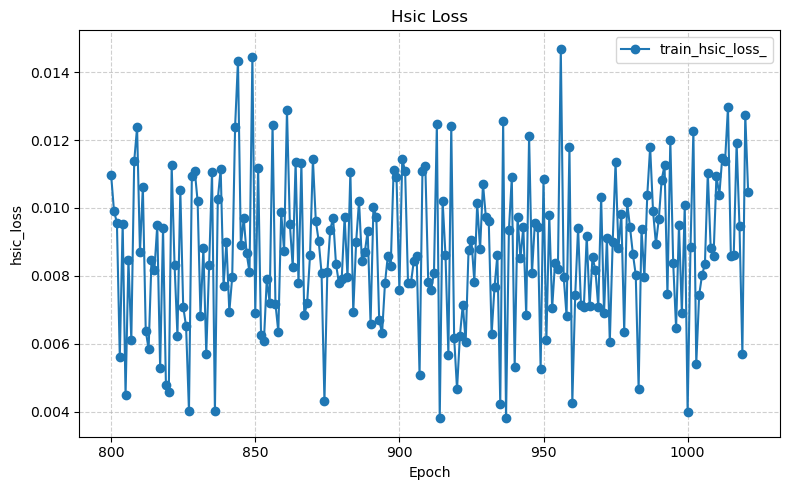

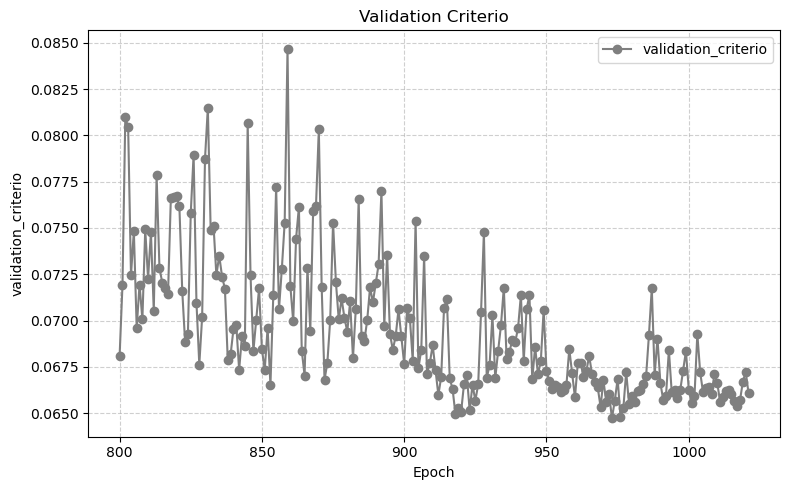

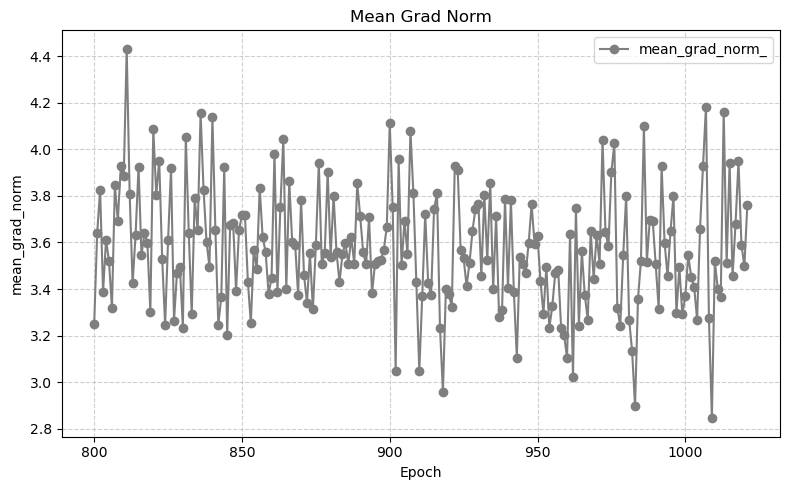

In [332]:
visualize_epoch_metrics(
 save_dir_path,
["val_prediction_loss_", "val_variance_loss_high_energy", "val_prediction_loss_high_energy", "val_variance_loss_training_set", "val_prediction_loss_training_set",  "val_variance_loss_", "train_total_loss_", "train_repulsion_loss_", "train_hsic_loss_" , "validation_criterio", "mean_grad_norm_"],
plot_on_same_graph=True,
verbose=True,
specific_epochs=[800, "last"]
)




📊 Processing directory: val_trajectories_data

For the epoch_325 in val_trajectories_data the values are:
58: X_mean = -0.0379 ± 0.0594, U_mean = -2.1890 ± 0.0387 and A=1.2861003281447578, phi=3.10971502940812
60: X_mean = -0.0464 ± 0.0249, U_mean = 0.3507 ± 0.0277 and A=1.302803629599372, phi=0.3584896193449746
31: X_mean = -1.2760 ± 0.0216, U_mean = -0.6391 ± 0.0371 and A=1.034538675096427, phi=-1.0225411941027112

📊 Processing directory: val_train_set_trajectories_data

For the epoch_325 in val_train_set_trajectories_data the values are:
26: X_mean = -0.5766 ± 0.0169, U_mean = -0.0268 ± 0.0439 and A=0.9808986503009178, phi=-0.10350682800806513
51: X_mean = -1.4027 ± 0.0188, U_mean = -0.4571 ± 0.0347 and A=1.225847748581651, phi=-0.9160542480716283
20: X_mean = -1.0343 ± 0.0309, U_mean = -1.5028 ± 0.0510 and A=0.9123773519944653, phi=-1.9937946817401142

📊 Processing directory: val_high_energy_trajectories_data

For the epoch_325 in val_high_energy_trajectories_data the values are:


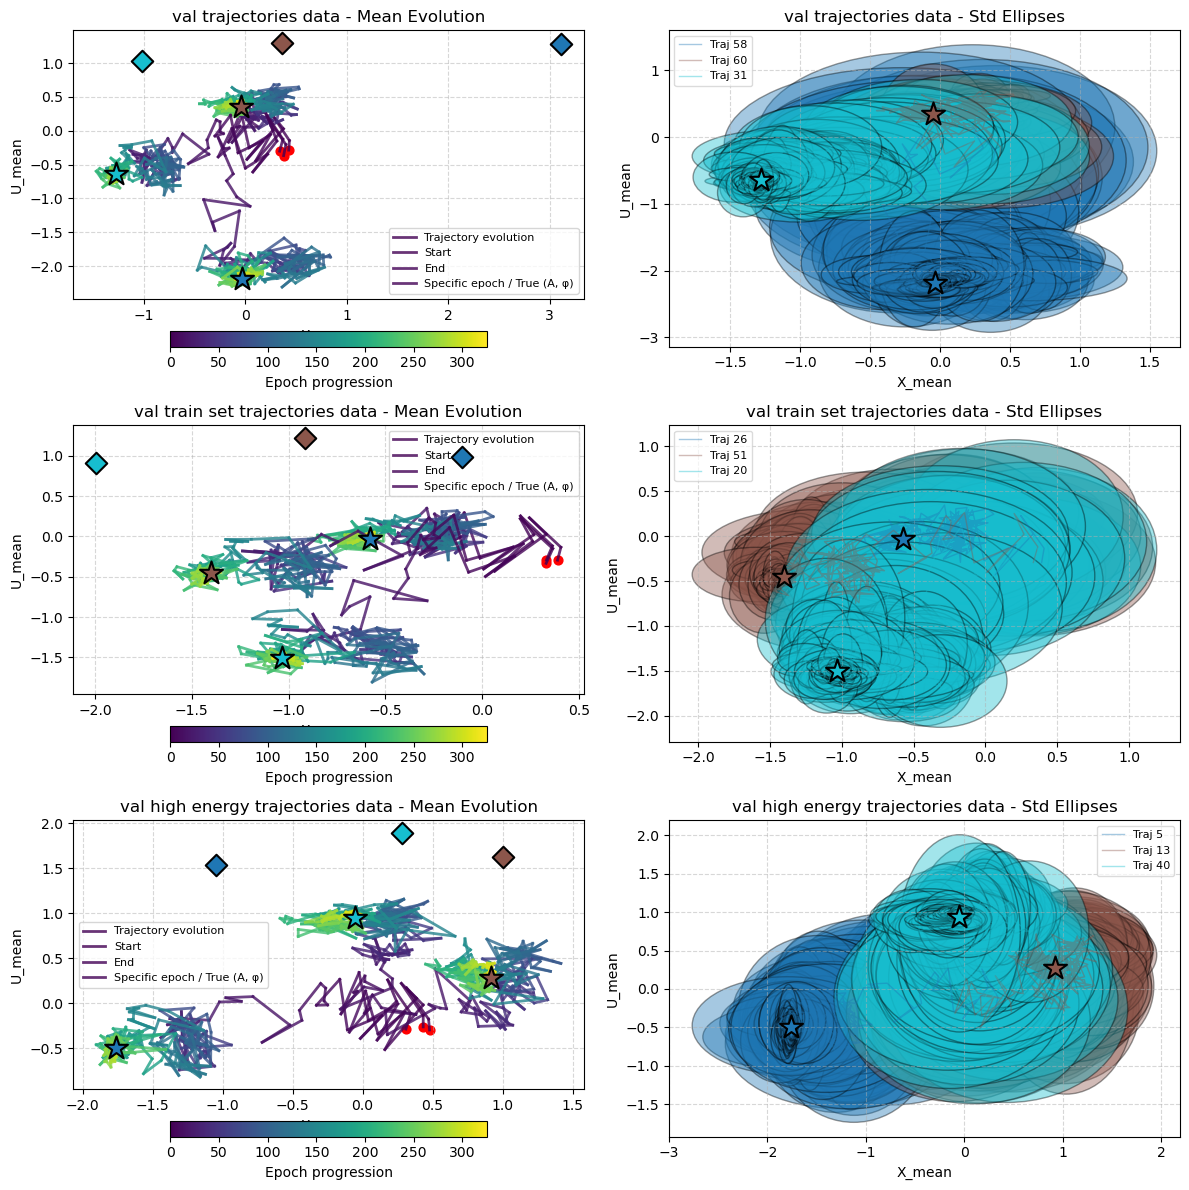


✅ Mean + Std (ellipse) visualization complete.


In [182]:
visualize_trajectory_movements_with_std_ellipses(save_dir_path, number_of_points_to_plot=3, right_plot_alpha=0.4, verbose=True, specific_epoch = "last", visualize_true_constants=True,train_id_df_added=train_id_df_low_samples_added,val_id_df_added=val_id_df_low_samples_added,val_id_df_high_energy_added=val_id_df_high_energy_low_samples_added)

In [333]:
val_differencies_df, val_train_differencies_set_df, val_high_energy_differencies_df = analyze_means_with_constants(
    save_dir_path=save_dir_path,
    specific_epoch=973,
    train_id_df_added=train_id_df_low_samples_added,
    val_id_df_added=val_id_df_low_samples_added,
    val_id_df_high_energy_added=val_id_df_high_energy_low_samples_added
)

📂 Using data from epoch: epoch_973
✅ Data extraction complete.


In [334]:
hsic_loss_statistics_only(
    x=torch.Tensor(val_train_differencies_set_df['A']),
    y=torch.Tensor(val_train_differencies_set_df['phi']),
    sigma_x = -1,
    sigma_y = -1,
    use_unbiased = True,
    epsilon = 1e-10)

tensor(0.0025)

In [335]:
hsic_loss_statistics_only(
    x=torch.Tensor(val_train_differencies_set_df['X_mean']),
    y=torch.Tensor(val_train_differencies_set_df['U_mean']),
    sigma_x = -1,
    sigma_y = -1,
    use_unbiased = True,
    epsilon = 1e-10)

tensor(0.)

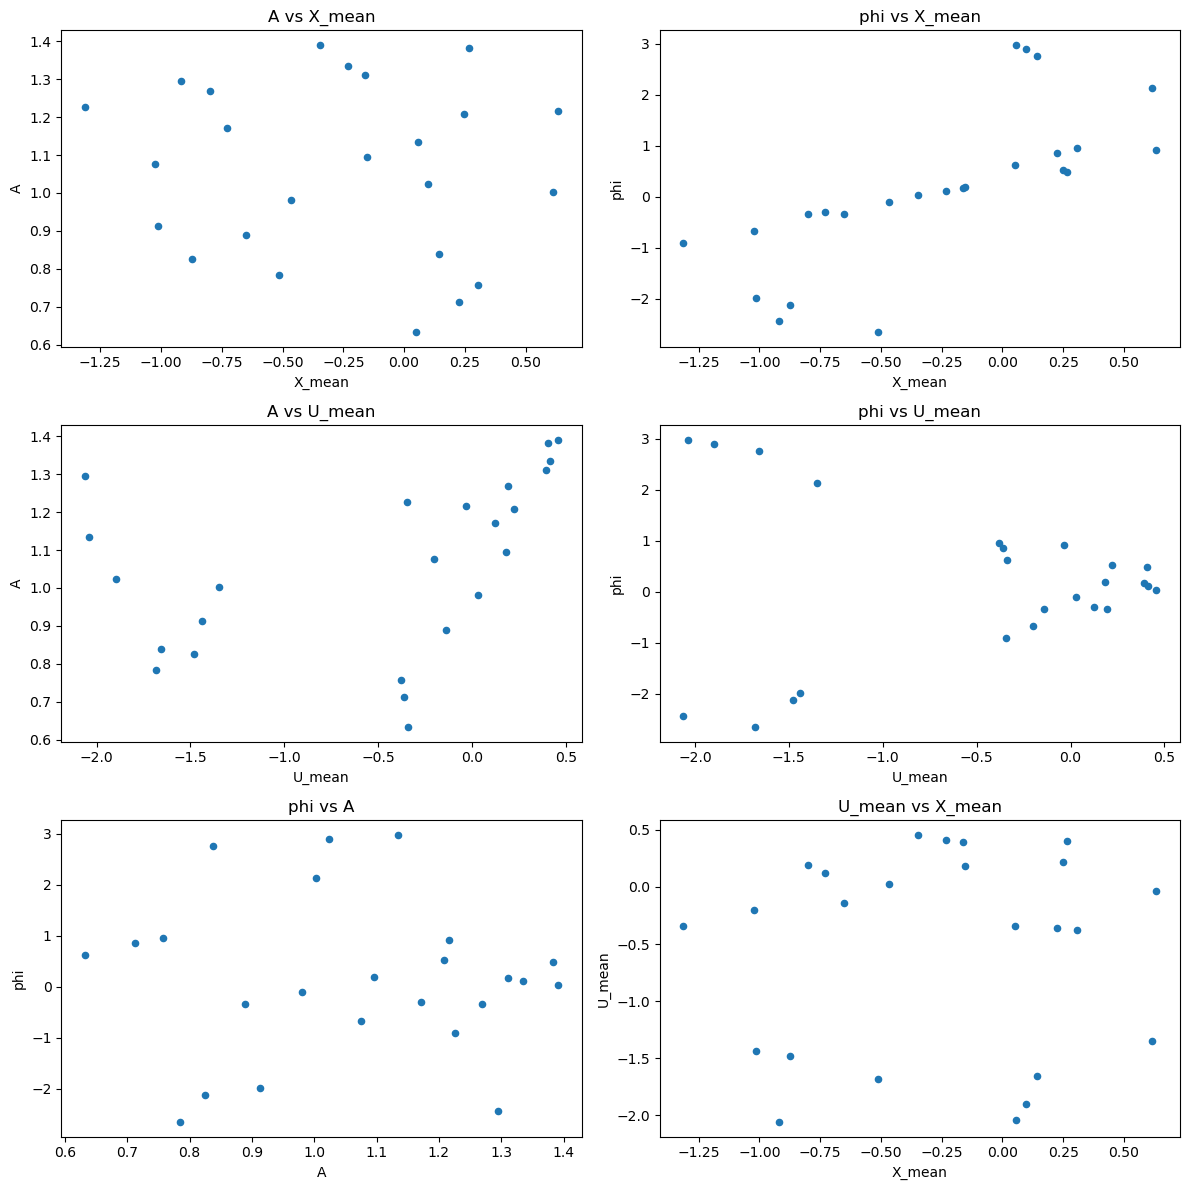

In [336]:
plot_differencies(val_train_differencies_set_df)

In [45]:
analyze_folders_means(save_dir_path, locate_epoch=None)

📊 Analyzing 94 epochs across 3 directories...

📁 Processing directory: val_trajectories_data

📁 Processing directory: val_train_set_trajectories_data

📁 Processing directory: val_high_energy_trajectories_data


KeyboardInterrupt: 

In [9]:
device = "cuda"
mapping_net = SimpleStackedHamiltonianNetwork(
        #Hpw many Step_1 + Step_2 layers to stack
    n_layers=10,
        # MLP Architecture parameters
    hidden_dims= [33, 60, 32],
    n_hidden_layers = None,   #Leave None if you provide list on hidden_dims
        
        # Activation parameters
    activation = 'gelu',
    activation_params = None,
    final_activation = None,   #Final layer activation function
    #final_activation_only_on_final_layer = True,
    tanh_wrapper = False,
        
        # Initialization parameters
    weight_init = 'orthogonal',
    weight_init_params = {'gain': 1},
    bias_init = 'zeros',
    bias_init_value = 0.0,
        
        
        # Architectural choices
    use_bias = True,
    use_layer_norm = False,
    
    # Input/Output parameters
    input_dim = 2,  # x or u and t
    output_dim = 1,  # scalar G or F
    a_eps_min= 0.5,  # Minimum value for a
    a_eps_max= 2,  # Maximum value for a  
    a_k= 0.1,

    step_1_a_mean_innit= 1.2,
    step_2_a_mean_innit= 1.2,
    std_to_mean_ratio_a_mean_init= 0.0,

    step_1_gamma_mean_innit= 0.5,
    step_2_gamma_mean_innit= 0.5,
    std_to_mean_ratio_gamma_mean_init= 0.0,

    step_1_c1_mean_innit= 0.0,
    step_2_c1_mean_innit= 0.0,
    std_to_mean_ratio_c1_mean_init= 1.0,

    step_1_c2_mean_innit= 0.0,
    step_2_c2_mean_innit= 0.0,
    std_to_mean_ratio_c2_mean_init= 1.0,

    bound_innit=0.0,
).to(device)

checkpoint_path = os.path.join(save_dir_path, "best_model.pt")

load_checkpoint(path=checkpoint_path, mapping_net=mapping_net, device=device, optimizer=None, scheduler=None)

inverse_net = InverseStackedHamiltonianNetwork(forward_network=mapping_net)


Successfully loaded model
Created inverse network with 10 reverse layers


/home/thomasdev/Desktop/Hamilton_Jacobi_NN/Hamilton_Jacobi_NN/modules.py:5601: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=devic

In [ ]:
test_canonical_tranformation_on_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, compute_jacobian_functional_function=compute_jacobian_functional, compute_symplectic_product_function=compute_symplectic_product, check_canonical_transformation_function=check_canonical_transformation, tolerance=1e-4, test_id_df=val_id_df_low_samples, test_df=val_df_low_samples, trajectory_id=57, mapping_net=mapping_net, inverse_net=inverse_net, device=device)

For the mapping network:
✓ All 32 transformations are canonical (preserve symplectic structure)!
  Maximum error across all samples: 3.58e-07
For the inverse network:
✓ All 32 transformations are canonical (preserve symplectic structure)!
  Maximum error across all samples: 5.96e-07


In [ ]:
print(f"Number of parameters are: {count_parameters(mapping_net)}, with number of training samples: {train_df_low_samples.shape[0]}\nThat is a ratio of parameters/samples of: {count_parameters(mapping_net)/train_df_low_samples.shape[0]}")

Number of parameters are: 82560, with number of training samples: 768
That is a ratio of parameters/samples of: 107.5


   num_observed_points  mean_loss
0                    1   0.024136
1                    2   0.022321
2                    3   0.019794
3                    4   0.019661
4                    5   0.018661
5                    6   0.018103
6                    7   0.016832
7                    8   0.015995
8                    9   0.015146
9                   10   0.014479


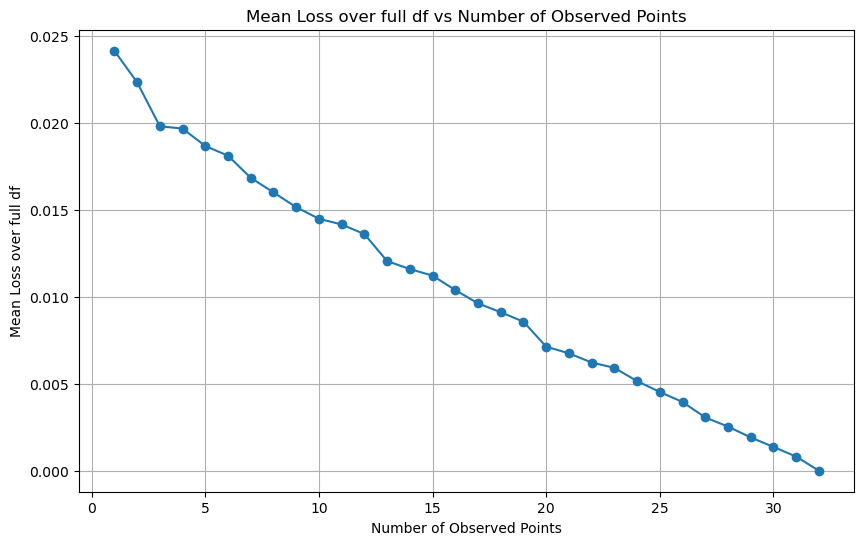

In [330]:
val_loss_per_points_df = test_model_with_varying_observed_points(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=val_id_df_low_samples, test_df=val_df_low_samples, mapping_net=mapping_net, inverse_net=inverse_net, device=device)

   num_observed_points  mean_variance
0                    1       0.000000
1                    2       0.002003
2                    3       0.001414
3                    4       0.001202
4                    5       0.001342
5                    6       0.001249
6                    7       0.001186
7                    8       0.001067
8                    9       0.001074
9                   10       0.001053


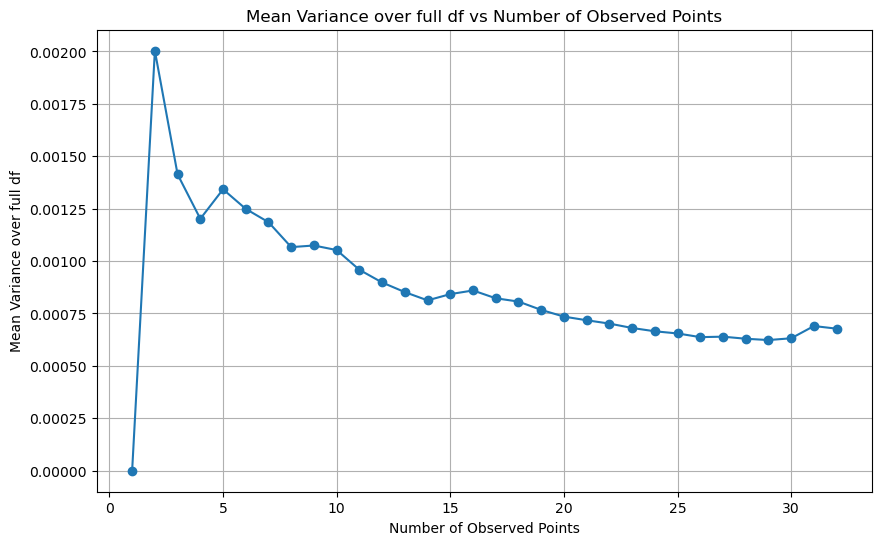

In [331]:
val_variance_per_points_df = test_model_variance_with_varying_observed_points(get_data_from_trajectory_id_function=get_data_from_trajectory_id ,test_id_df=val_id_df_low_samples, test_df=val_df_low_samples, mapping_net=mapping_net ,device=device)

In [10]:
point_indexes_observed = [0]

In [11]:
k=1
mass=1
constant = -(k / mass)
omega = np.sqrt(-constant)
period = 2*np.pi/omega
print(f"Period is constant and = {period:.3f}")

tmax_list = []
for idx, row in train_id_df_low_samples.iterrows():
    trajectory_id = int(row['trajectory_id'])
    start_index = int(row['start_index'])
    end_index = int(row['end_index'])
    
    test_trajectory_data = get_data_from_trajectory_id(train_id_df_low_samples, train_df_low_samples, trajectory_ids=trajectory_id)
    t = test_trajectory_data['t'].to_numpy(dtype=np.float32)
    tmax = max(t)
    tmax_list.append(tmax)
max_t_training = min(np.array(tmax_list))
dt = (t[1]-t[0]).item()

    

Period is constant and = 6.283


In [13]:
import logging
optuna.logging.set_verbosity(optuna.logging.WARNING)
# ---------------------------------------------------------
# 1. PREPARE FIXED ARGUMENTS
# ---------------------------------------------------------
# These arguments never change during the optimization.
# We pack them here to keep the objective function clean.
fixed_args = {
    "get_data_from_trajectory_id_function": get_data_from_trajectory_id,
    "prediction_loss_function": prediction_loss_euclidean,
    "test_id_df": val_id_df_low_samples,
    "test_df": val_df_low_samples,
    "mapping_net": mapping_net,
    "inverse_net": inverse_net,
    "device": device,
    "point_indexes_observed": point_indexes_observed,
    "recreate_and_plot_phase_space": False,
    "plot_specific_portion": 0.26,
    "connect_points": False,
    "plot_trajectories_subsample": 0.4,
    "max_t_training": max_t_training,
    "search_range_lower_pct": 0.1,  # Assuming this is fixed
    "verbose":False
}

# ---------------------------------------------------------
# 2. DEFINE THE OBJECTIVE FUNCTION
# ---------------------------------------------------------
def objective(trial):
    """
    This function runs ONE experiment. 
    Optuna provides the 'trial' object which we use to select params.
    """
    
    # A. Suggest the Boolean switch first
    efficiently_param = trial.suggest_categorical("efficiently", [True, False])
    
    # B. Conditional Logic (The Bayesian part)
    # Optuna's sampler will learn that 'threshold' is only relevant when efficiently=False
    if efficiently_param:
        # If efficient, passed params don't matter, but we must pass something to avoid errors
        threshold_param = 1.0 
        upper_pct_param = 0.6 
    else:
        # If NOT efficient, Optuna suggests values within your specified ranges
        # suggest_float(name, low, high)
        threshold_param = trial.suggest_float("threshold", 0.1, 3.0) 
        upper_pct_param = trial.suggest_float("search_range_upper_pct", 0.2, 0.9)

    # C. Run your actual function
    # We handle exceptions so one bad run doesn't crash the whole study
    try:
        _, mean_loss = test_model_in_all_trajectories_in_df(
            efficiently=efficiently_param,
            threshold=threshold_param,
            search_range_upper_pct=upper_pct_param,
            **fixed_args
        )
    except Exception as e:
        print(f"Trial failed: {e}")
        # Return infinity so Optuna knows this was a terrible run
        return float('inf')

    # D. Return the value we want to MINIMIZE
    return mean_loss

# ---------------------------------------------------------
# 3. RUN THE OPTIMIZATION (THE STUDY)
# ---------------------------------------------------------
print("Starting Bayesian Optimization...")

# Create the study. We want to 'minimize' the loss.
study = optuna.create_study(direction="minimize")

# n_trials=20 means it will run your function 20 times. 
# Increase this to 50 or 100 if you have time.
study.optimize(objective, n_trials=30, show_progress_bar=True)

# ---------------------------------------------------------
# 4. VIEW RESULTS
# ---------------------------------------------------------
print("-" * 30)
print("BEST RESULTS FOUND:")
print(f"Best Mean Loss: {study.best_value}")
print("Best Hyperparameters:", study.best_params)

# If you want to see all trials as a DataFrame:
df_results = study.trials_dataframe()
# print(df_results)

Starting Bayesian Optimization...


Best trial: 20. Best value: 0.0105614: 100%|██████████| 30/30 [18:02<00:00, 36.09s/it]

------------------------------
BEST RESULTS FOUND:
Best Mean Loss: 0.010561358314007521
Best Hyperparameters: {'efficiently': False, 'threshold': 1.2135479103134015, 'search_range_upper_pct': 0.432847454492039}


In [15]:
import logging
optuna.logging.set_verbosity(optuna.logging.WARNING)
# ---------------------------------------------------------
# 1. PREPARE FIXED ARGUMENTS
# ---------------------------------------------------------
# These arguments never change during the optimization.
# We pack them here to keep the objective function clean.
fixed_args = {
    "get_data_from_trajectory_id_function": get_data_from_trajectory_id,
    "prediction_loss_function": prediction_loss_euclidean,
    "test_id_df": val_id_df_low_samples,
    "test_df": val_df_low_samples,
    "mapping_net": mapping_net,
    "inverse_net": inverse_net,
    "device": device,
    "point_indexes_observed": point_indexes_observed,
    "recreate_and_plot_phase_space": False,
    "plot_specific_portion": 0.26,
    "connect_points": False,
    "plot_trajectories_subsample": 0.4,
    "max_t_training": max_t_training,
    "efficiently": False,
    "method": "gaussian_mixture_simple",
    "threshold": 1.0,
    "dt": dt,
    "alpha":1.0,
    "gamma":1.0,
    "cluster_weight_threshold": 0.4,
    "search_range_lower_pct": 0.1,  # Assuming this is fixed
    "verbose":False
}

# ---------------------------------------------------------
# 2. DEFINE THE OBJECTIVE FUNCTION
# ---------------------------------------------------------
def objective(trial):
    """
    This function runs ONE experiment. 
    Optuna provides the 'trial' object which we use to select params.
    """
    

    # B. Conditional Logic (The Bayesian part)
    # Optuna's sampler will learn that 'threshold' is only relevant when efficiently=False

        
    # suggest_float(name, low, high)

    search_range_upper_pct_param = trial.suggest_float("search_range_upper_pct", 0.3, 0.7) 
    max_n_components_param = trial.suggest_int("max_n_components", 2, 5)

    # C. Run your actual function
    # We handle exceptions so one bad run doesn't crash the whole study
    try:
        _, mean_loss = test_model_in_all_trajectories_in_df(
            search_range_upper_pct = search_range_upper_pct_param,
            max_n_components = max_n_components_param,
            **fixed_args
        )
    except Exception as e:
        print(f"Trial failed: {e}")
        # Return infinity so Optuna knows this was a terrible run
        return float('inf')

    # D. Return the value we want to MINIMIZE
    return mean_loss

# ---------------------------------------------------------
# 3. RUN THE OPTIMIZATION (THE STUDY)
# ---------------------------------------------------------
print("Starting Bayesian Optimization...")

# Create the study. We want to 'minimize' the loss.
study = optuna.create_study(direction="minimize")

# n_trials=20 means it will run your function 20 times. 
# Increase this to 50 or 100 if you have time.
study.optimize(objective, n_trials=20, show_progress_bar=True)

# ---------------------------------------------------------
# 4. VIEW RESULTS
# ---------------------------------------------------------
print("-" * 30)
print("BEST RESULTS FOUND:")
print(f"Best Mean Loss: {study.best_value}")
print("Best Hyperparameters:", study.best_params)

# If you want to see all trials as a DataFrame:
df_results = study.trials_dataframe()
# print(df_results)

Starting Bayesian Optimization...


Best trial: 15. Best value: 0.0117959: 100%|██████████| 20/20 [2:32:04<00:00, 456.25s/it] 

------------------------------
BEST RESULTS FOUND:
Best Mean Loss: 0.011795881241559981
Best Hyperparameters: {'search_range_upper_pct': 0.4272842927260936, 'max_n_components': 2}


    trajectory_id    energy  prediction_loss  loss_per_sqrt_energy
1               1  0.210811         0.025700              0.055975
3               3  0.232432         0.025012              0.051881
4               4  0.243243         0.024220              0.049107
7               7  0.275676         0.017064              0.032499
11             11  0.318919         0.017400              0.030811
16             16  0.372973         0.026669              0.043669
19             19  0.405405         0.017174              0.026972
22             22  0.437838         0.030053              0.045418
23             23  0.448649         0.020537              0.030661
27             27  0.491892         0.019806              0.028240
31             31  0.535135         0.024049              0.032875
32             32  0.545946         0.030290              0.040994
34             34  0.567568         0.027971              0.037128
38             38  0.610811         0.016410              0.02

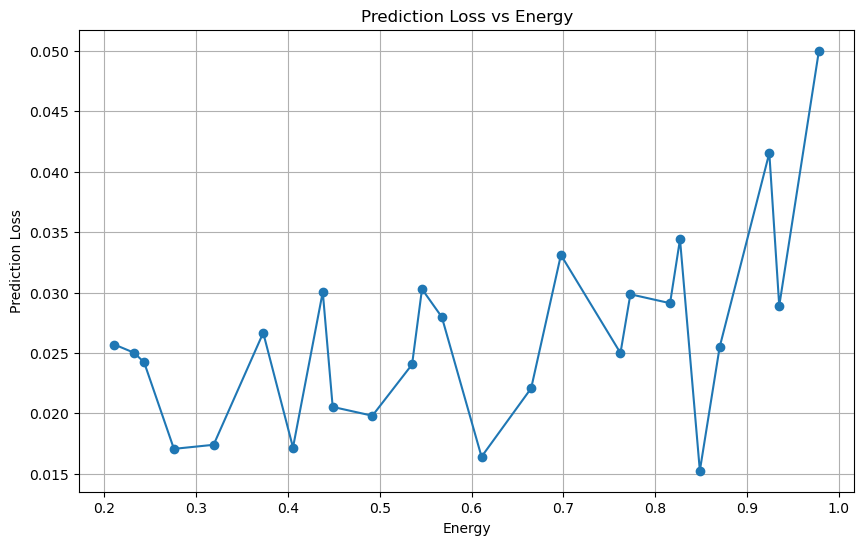

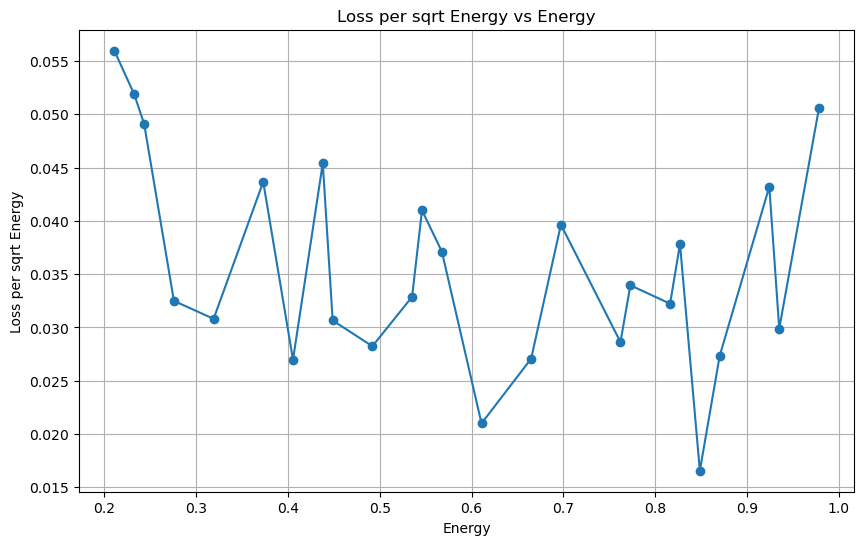

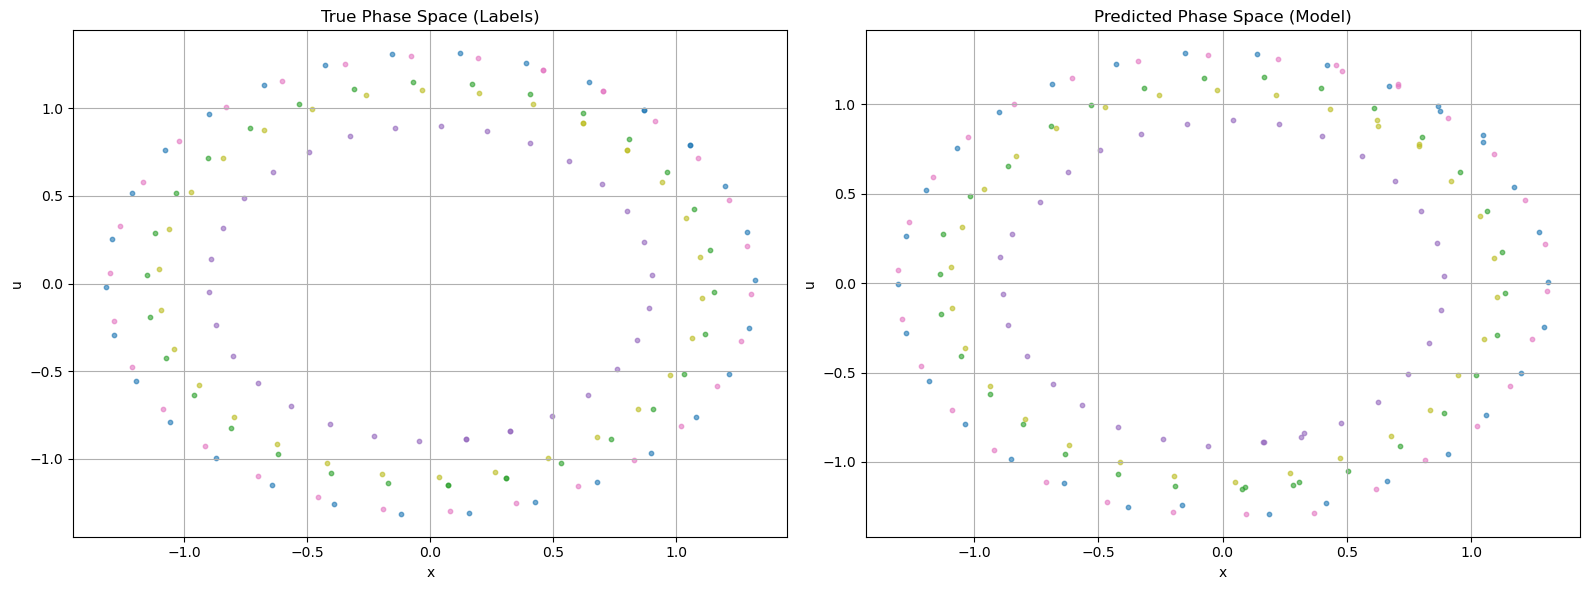

In [ ]:
prediction_val_df, mean_prediction_loss_val, pred_val_df = test_model_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=val_id_df_low_samples, test_df=val_df_low_samples, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, recreate_and_plot_phase_space=True, plot_specific_portion=1.0, connect_points=False, plot_trajectories_subsample=0.2, max_t_training=max_t_training, efficiently=True, threshold=1.0, search_range_lower_pct=0.5, search_range_upper_pct=0.6, verbose=True)

 efficiently=False, method="gaussian_mixture_simple", threshold=1.2135479103134015, dt=dt, alpha=1.0, gamma=1.0, cluster_weight_threshold=0.4, max_n_components=, search_range_lower_pct=0.1, search_range_upper_pct=, verbose=True

    trajectory_id    energy  prediction_loss  loss_per_sqrt_energy
1               1  0.210811         0.015406              0.033554
3               3  0.232432         0.013211              0.027402
4               4  0.243243         0.011806              0.023938
7               7  0.275676         0.004837              0.009212
11             11  0.318919         0.012821              0.022703
16             16  0.372973         0.013047              0.021364
19             19  0.405405         0.007067              0.011099
22             22  0.437838         0.008150              0.012317
23             23  0.448649         0.013855              0.020685
27             27  0.491892         0.008788              0.012531
31             31  0.535135         0.013101              0.017908
32             32  0.545946         0.007307              0.009889
34             34  0.567568         0.008121              0.010779
38             38  0.610811         0.013023              0.01

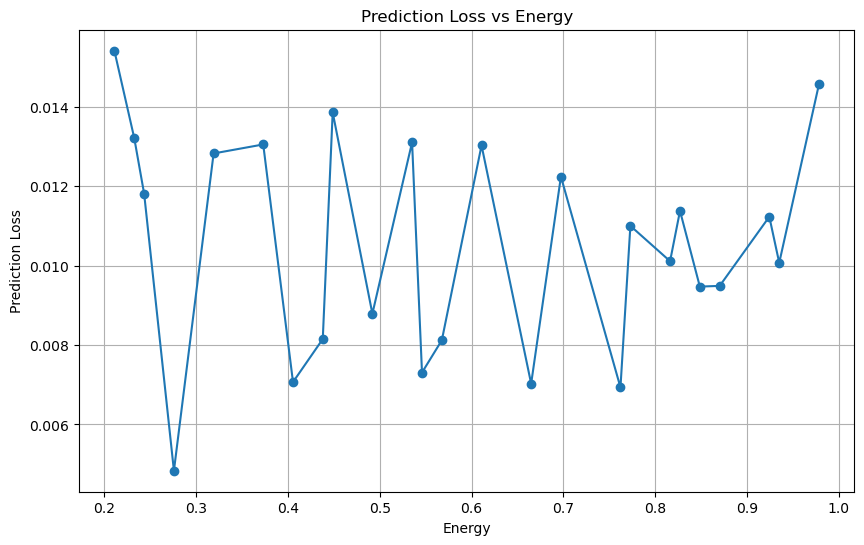

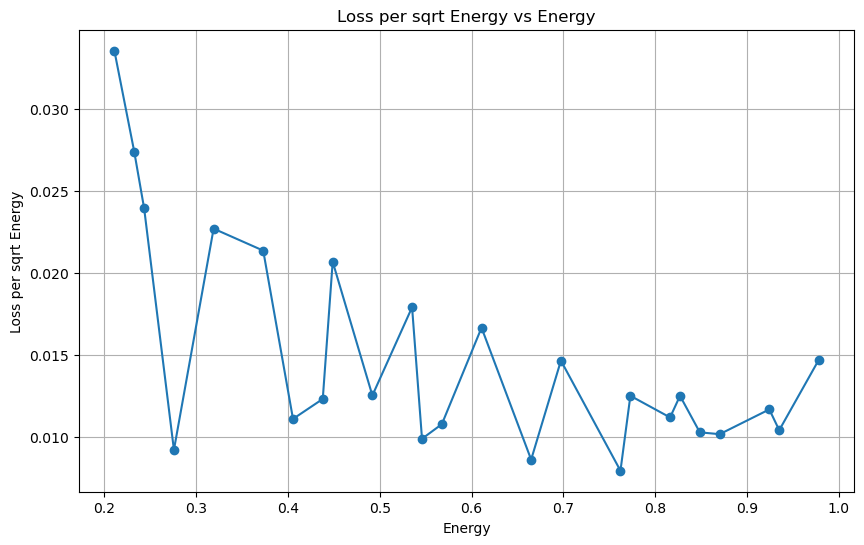

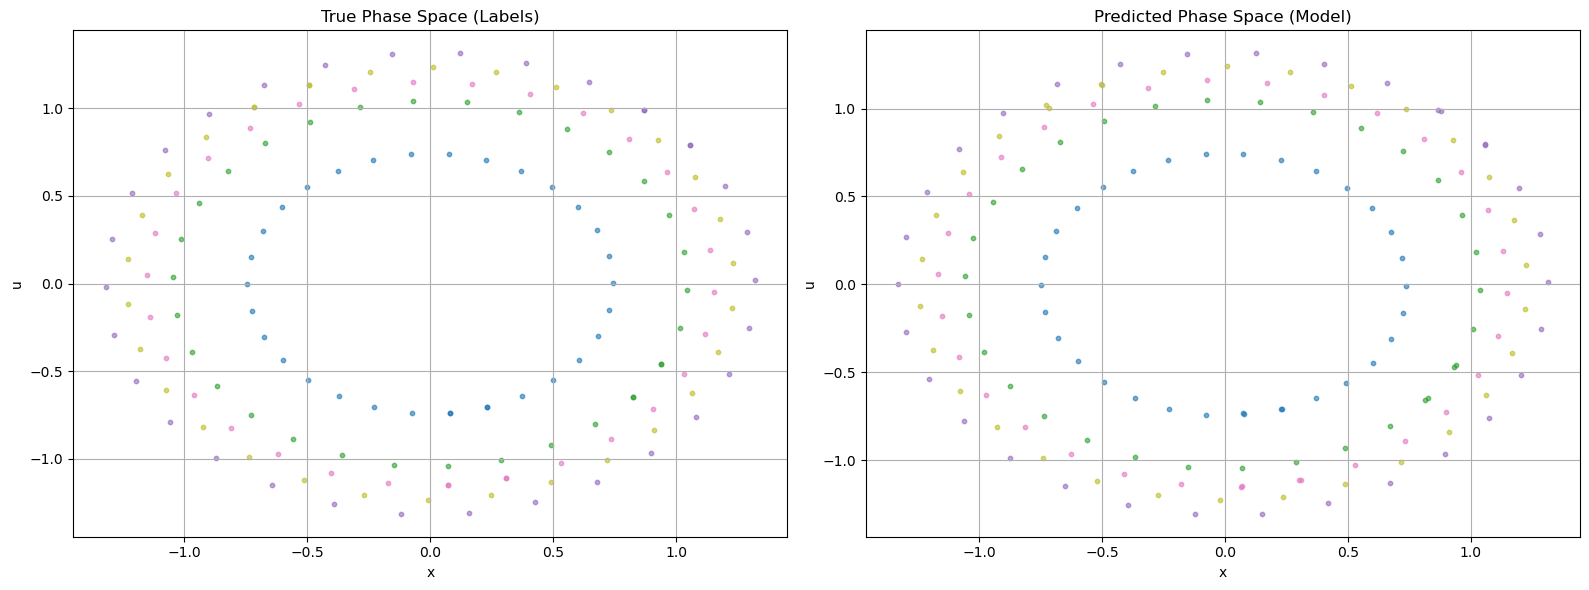

In [ ]:
prediction_val_ensemble_df, mean_prediction_loss_val_ensemble, _ = test_model_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=val_id_df_low_samples, test_df=val_df_low_samples, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, recreate_and_plot_phase_space=True, plot_specific_portion=1.0, connect_points=False, plot_trajectories_subsample=0.2, max_t_training=max_t_training efficiently=False, method="gaussian_mixture_simple", threshold=0.8947378594655051, dt=dt, alpha=1.0, gamma=1.0, cluster_weight_threshold=0.4, max_n_components=4, search_range_lower_pct=0.1, search_range_upper_pct=0.5159009375433774, verbose=True)

    trajectory_id    energy  variance_loss  variance_per_sqrt_energy
1               1  0.210811            0.0                       0.0
3               3  0.232432            0.0                       0.0
4               4  0.243243            0.0                       0.0
7               7  0.275676            0.0                       0.0
11             11  0.318919            0.0                       0.0
16             16  0.372973            0.0                       0.0
19             19  0.405405            0.0                       0.0
22             22  0.437838            0.0                       0.0
23             23  0.448649            0.0                       0.0
27             27  0.491892            0.0                       0.0
31             31  0.535135            0.0                       0.0
32             32  0.545946            0.0                       0.0
34             34  0.567568            0.0                       0.0
38             38  0.610811       

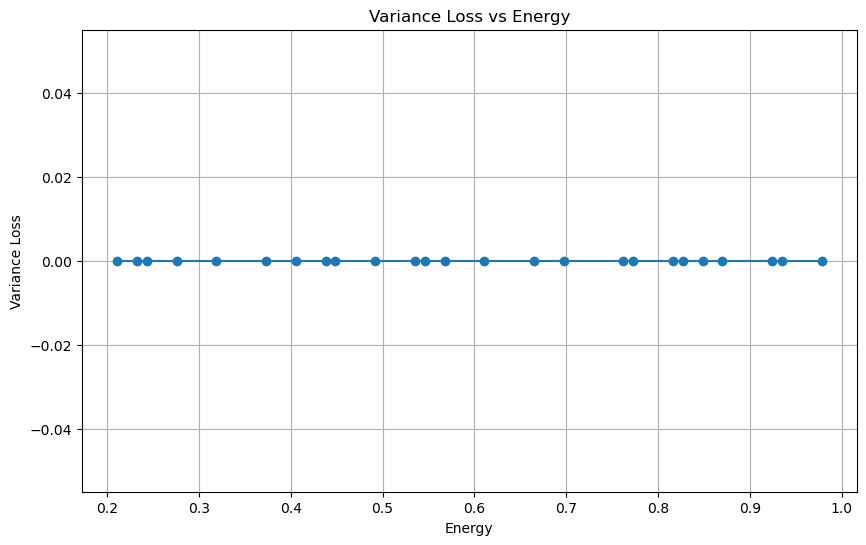

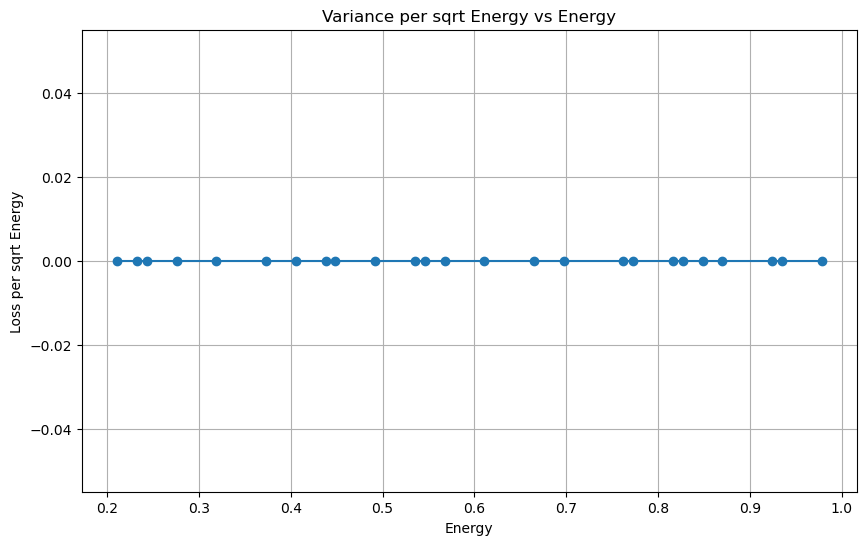

In [18]:
variance_val_df, mean_variance_loss_val = test_model_variance_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, test_id_df=val_id_df_low_samples, test_df=val_df_low_samples, mapping_net=mapping_net, device=device, point_indexes_observed=point_indexes_observed)


In [17]:
trajectory_id_val = 60
trajectory_id_val_ensemble = 52


=== Efficient Method - Forward Pass Count ===
mapping_net calls: 1
inverse_net calls: 1
Total forward passes: 2
Observed time points: [0.]


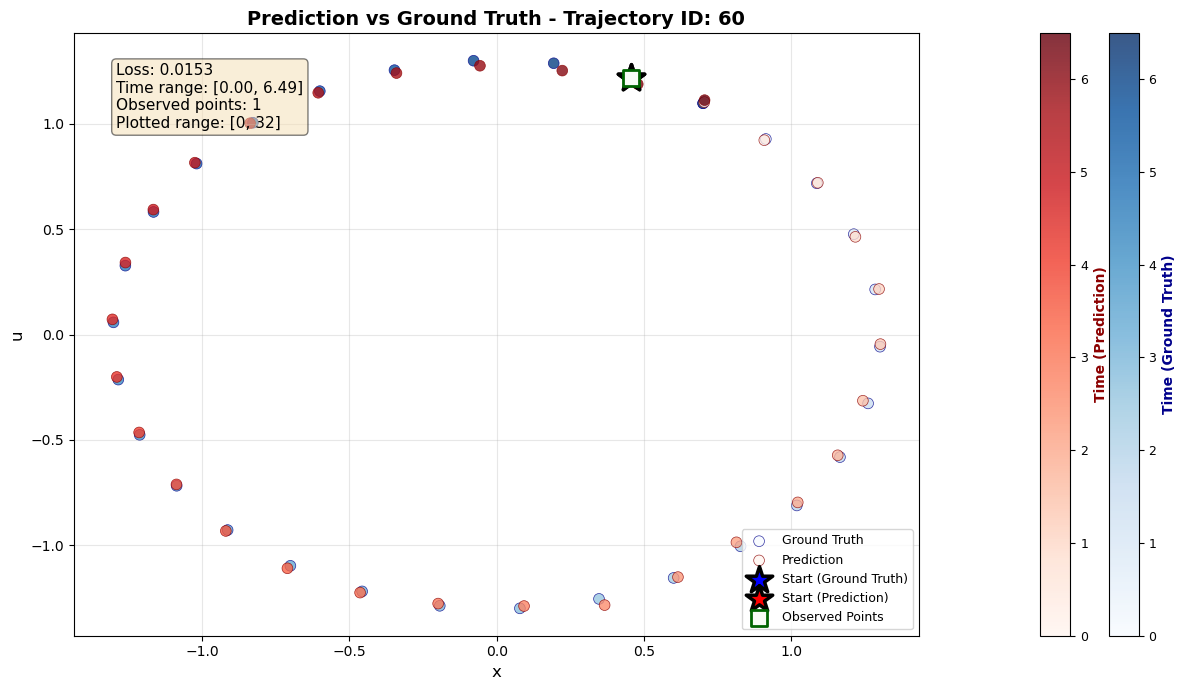

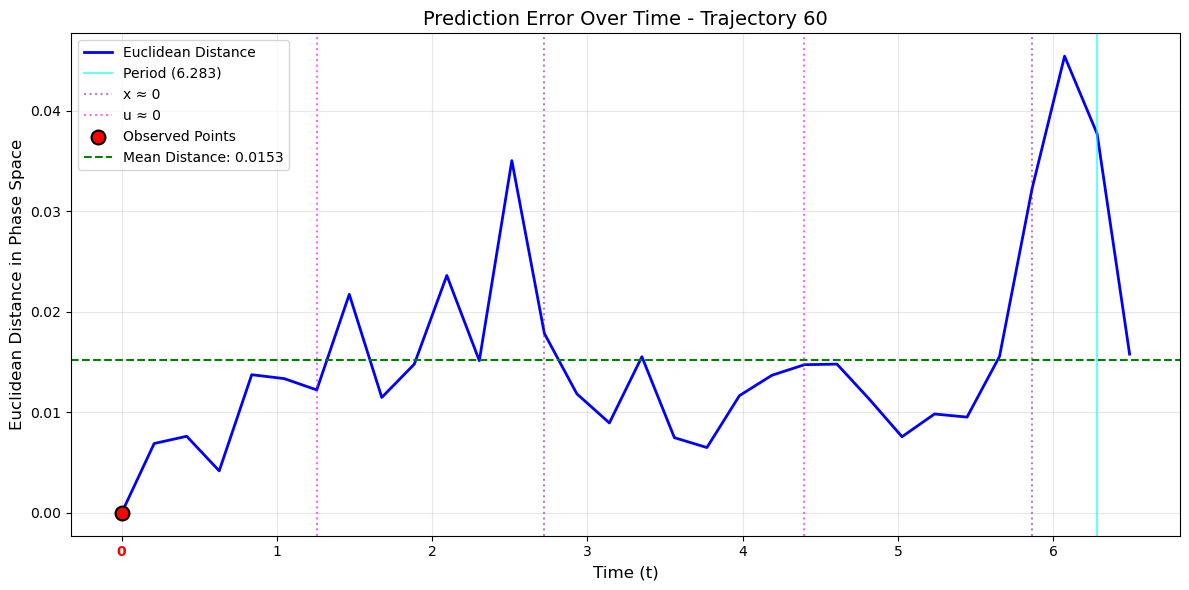

In [18]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=val_id_df_low_samples, test_df=val_df_low_samples, trajectory_id=trajectory_id_val, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, connect_points=False, portion_to_visualize=[0,32], show_zeroings=True, show_period=True, period=period, max_t_training=max_t_training, efficiently=True, threshold=1.0, search_range_lower_pct=0.5, search_range_upper_pct=0.6, verbose=True)


=== Ensemble Method - Forward Pass Count ===
mapping_net calls: 3
inverse_net calls: 94
Total forward passes: 97
Coverage: 100.0%
Observed time points: [0.]


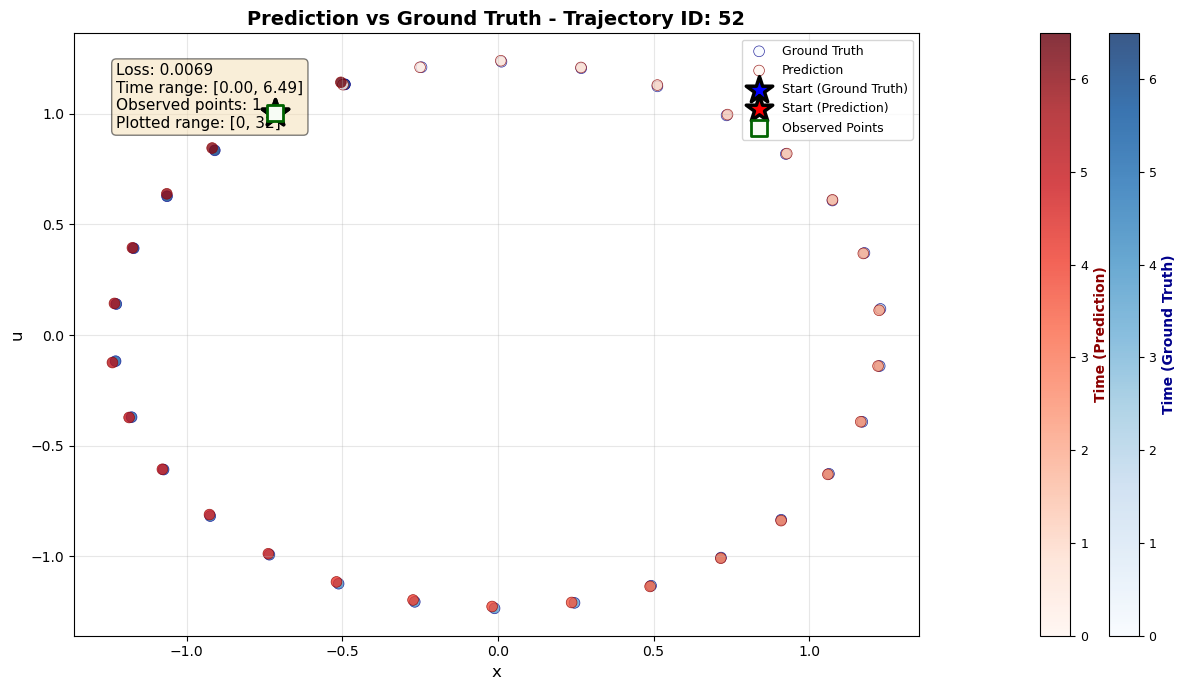

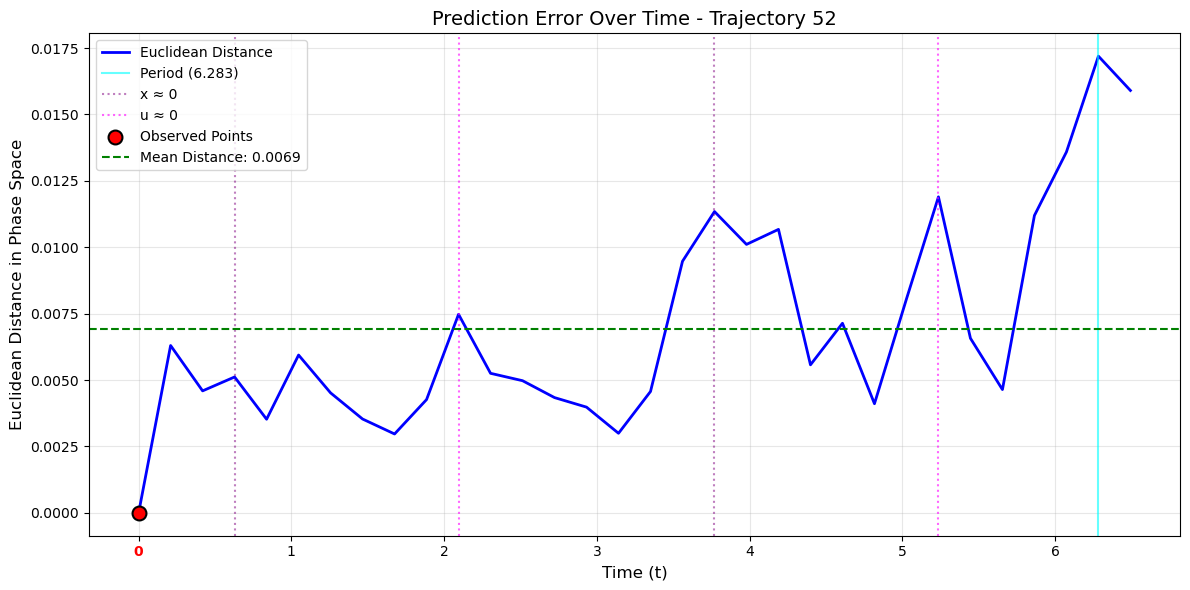

In [19]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=val_id_df_low_samples, test_df=val_df_low_samples, trajectory_id=trajectory_id_val_ensemble, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, connect_points=False, portion_to_visualize=[0,32], show_zeroings=True, show_period=True, period=period, max_t_training=max_t_training, efficiently=False, threshold=1.2135479103134015, search_range_lower_pct=0.1, search_range_upper_pct=0.432847454492039, verbose=True)

    trajectory_id    energy  prediction_loss  loss_per_sqrt_energy
2               2  0.221622         0.020828              0.044242
6               6  0.264865         0.025559              0.049664
9               9  0.297297         0.026703              0.048973
12             12  0.329730         0.026632              0.046379
15             15  0.362162         0.028282              0.046996
17             17  0.383784         0.029486              0.047596
21             21  0.427027         0.029366              0.044939
24             24  0.459459         0.030944              0.045651
25             25  0.470270         0.017682              0.025785
29             29  0.513514         0.013067              0.018235
33             33  0.556757         0.020495              0.027467
36             36  0.589189         0.021092              0.027478
39             39  0.621622         0.025642              0.032523
40             40  0.632432         0.025938              0.03

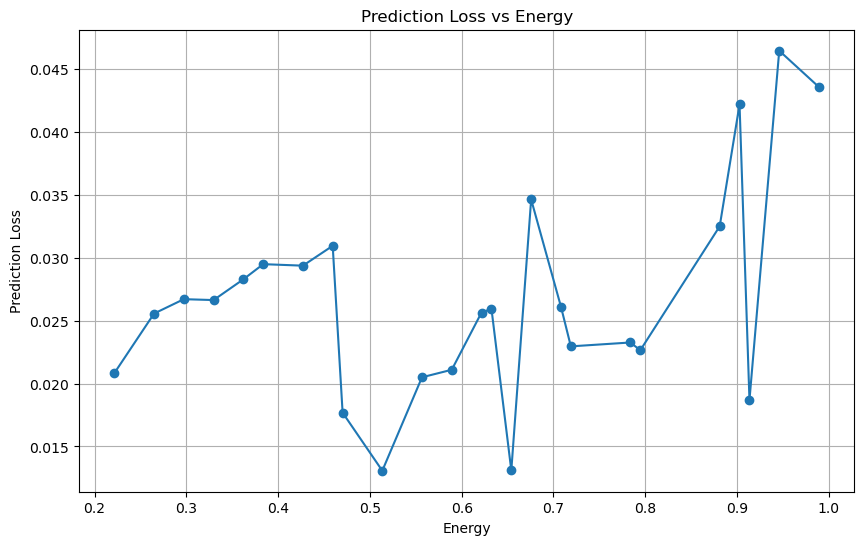

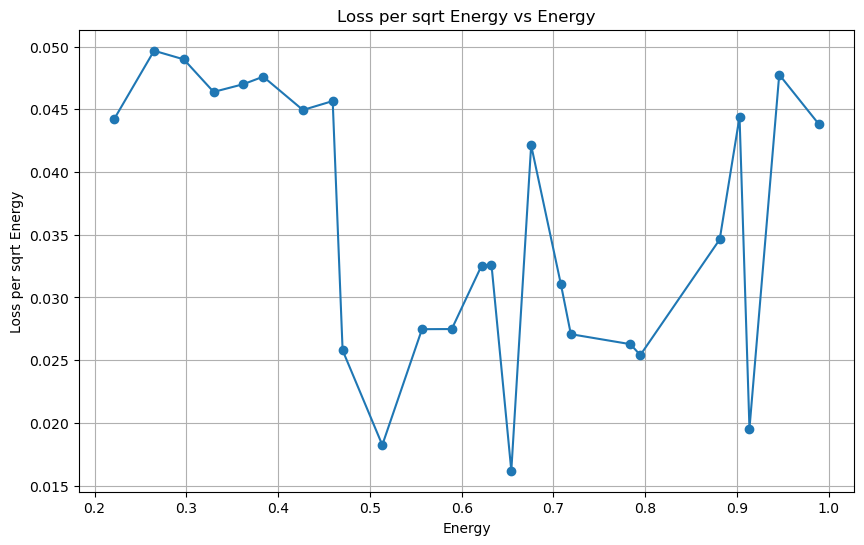

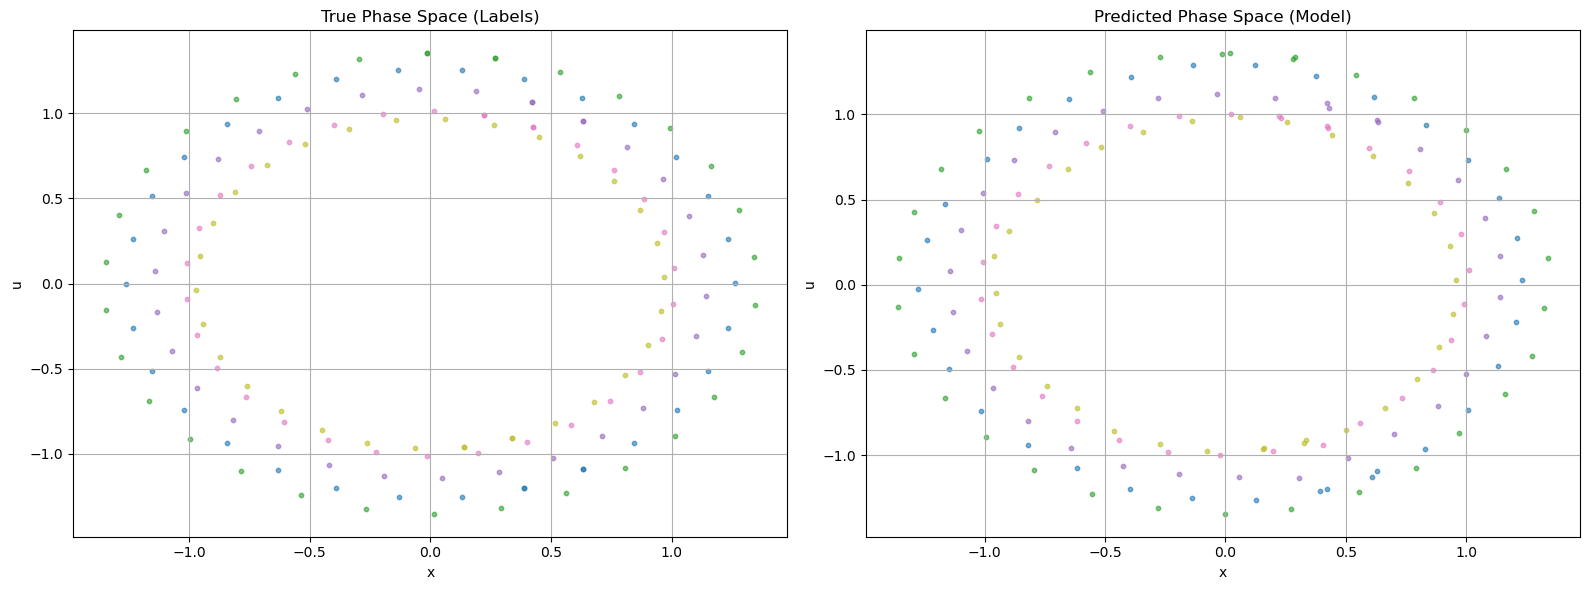

In [ ]:
prediction_test_df, mean_prediction_loss_test, pred_test_df = test_model_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_low_samples, test_df=test_df_low_samples, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, recreate_and_plot_phase_space=True, plot_specific_portion=1.0, connect_points=False, plot_trajectories_subsample=0.2, max_t_training=max_t_training, efficiently=True, threshold=1.0, search_range_lower_pct=0.5, search_range_upper_pct=0.6, verbose=True)

    trajectory_id    energy  prediction_loss  loss_per_sqrt_energy
2               2  0.221622         0.010288              0.021853
6               6  0.264865         0.011651              0.022639
9               9  0.297297         0.013805              0.025319
12             12  0.329730         0.013587              0.023662
15             15  0.362162         0.010552              0.017534
17             17  0.383784         0.006431              0.010381
21             21  0.427027         0.007444              0.011391
24             24  0.459459         0.007347              0.010839
25             25  0.470270         0.008723              0.012720
29             29  0.513514         0.010662              0.014879
33             33  0.556757         0.009520              0.012759
36             36  0.589189         0.010690              0.013927
39             39  0.621622         0.008916              0.011308
40             40  0.632432         0.014589              0.01

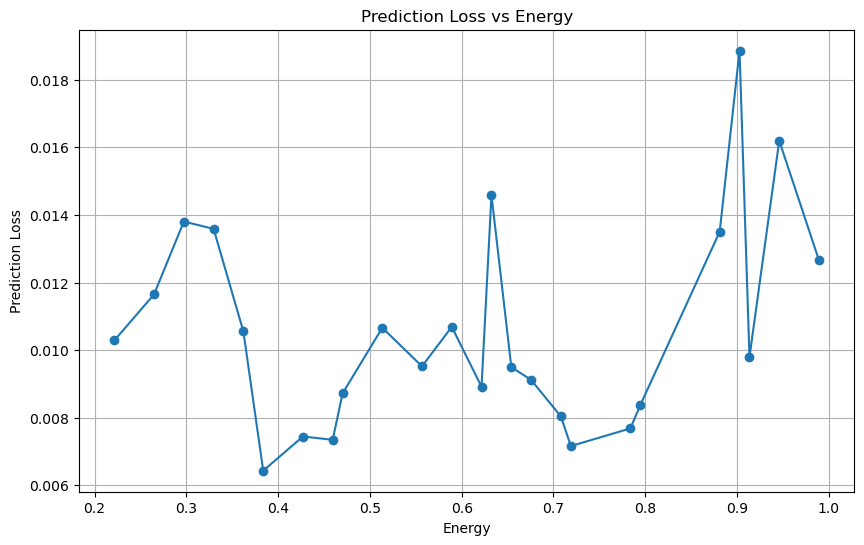

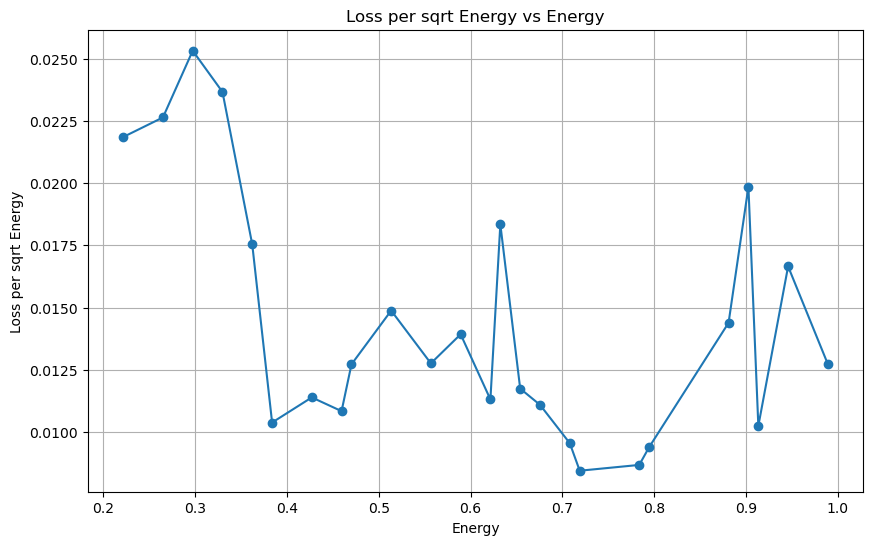

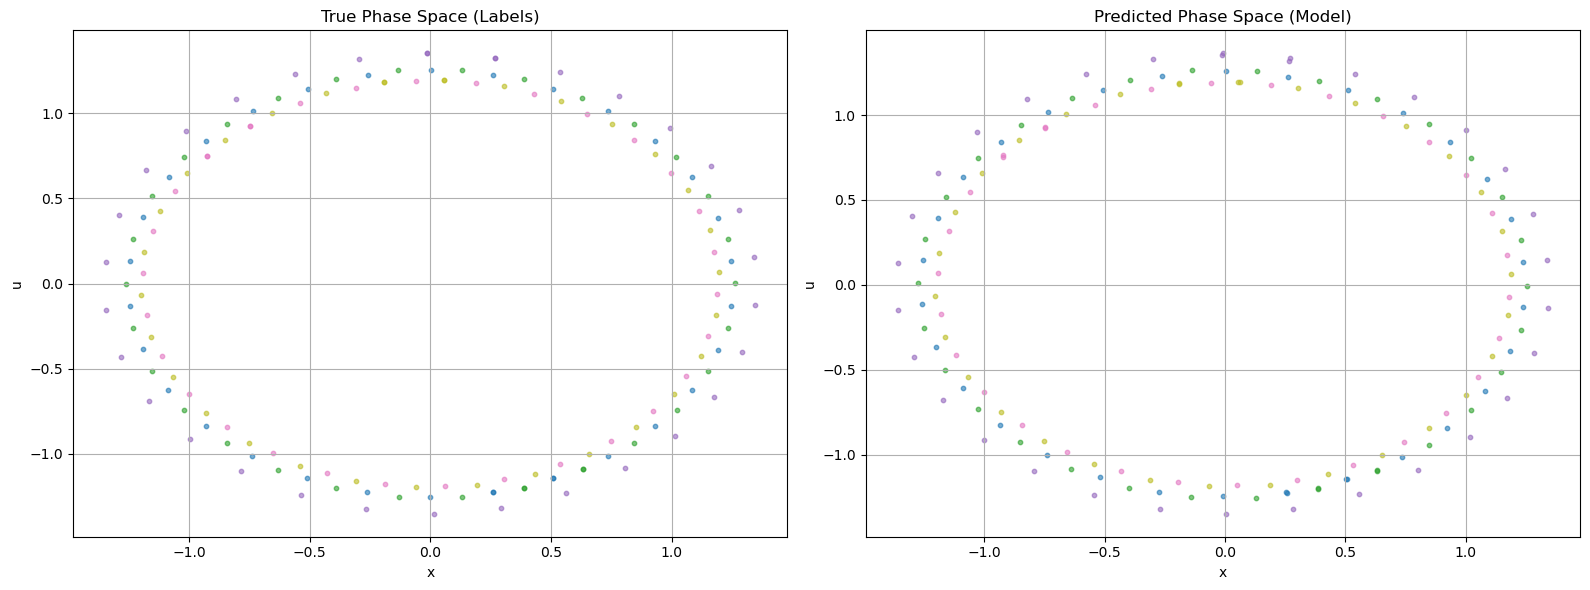

In [25]:
prediction_test_ensemble_df, mean_prediction_loss_test_ensemble, pred_test_ensemble_df = test_model_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_low_samples, test_df=test_df_low_samples, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, recreate_and_plot_phase_space=True, plot_specific_portion=1.0, connect_points=False, plot_trajectories_subsample=0.2, max_t_training=max_t_training, efficiently=False, threshold=1.2135479103134015, search_range_lower_pct=0.1, search_range_upper_pct=0.432847454492039, verbose=True)

    trajectory_id    energy  variance_loss  variance_per_sqrt_energy
2               2  0.221622            0.0                       0.0
6               6  0.264865            0.0                       0.0
9               9  0.297297            0.0                       0.0
12             12  0.329730            0.0                       0.0
15             15  0.362162            0.0                       0.0
17             17  0.383784            0.0                       0.0
21             21  0.427027            0.0                       0.0
24             24  0.459459            0.0                       0.0
25             25  0.470270            0.0                       0.0
29             29  0.513514            0.0                       0.0
33             33  0.556757            0.0                       0.0
36             36  0.589189            0.0                       0.0
39             39  0.621622            0.0                       0.0
40             40  0.632432       

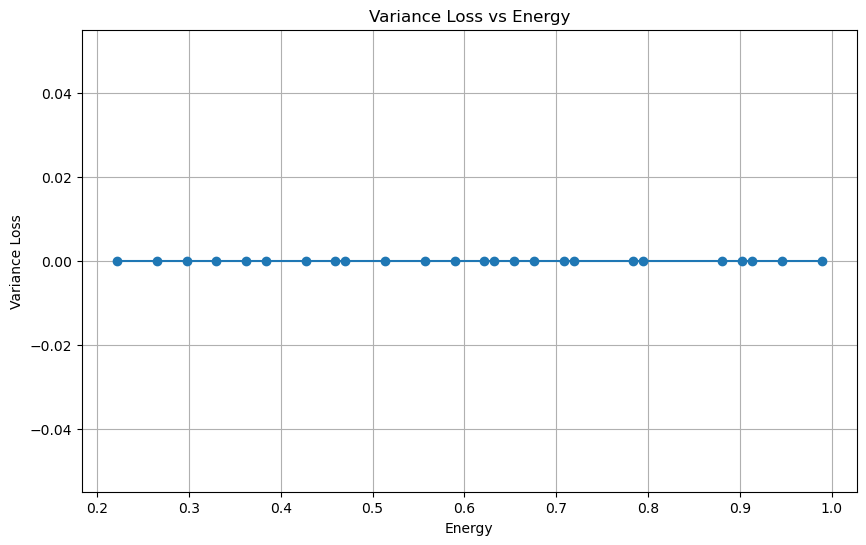

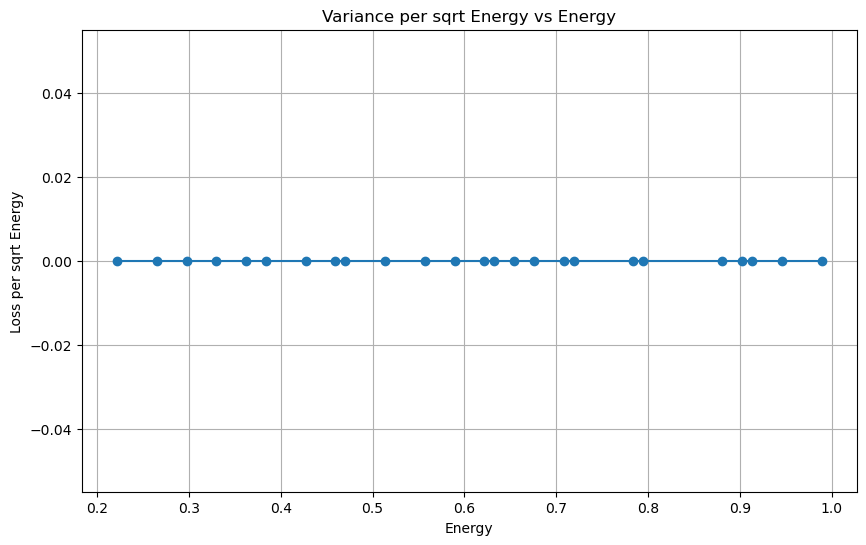

In [22]:
variance_test_df, mean_variance_loss_test = test_model_variance_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, test_id_df=test_id_df_low_samples, test_df=test_df_low_samples, mapping_net=mapping_net, device=device, point_indexes_observed=point_indexes_observed)


In [22]:
trajectory_id_test = 42
trajectory_id_test_ensemble = 48


=== Efficient Method - Forward Pass Count ===
mapping_net calls: 1
inverse_net calls: 1
Total forward passes: 2
Observed time points: [0.]


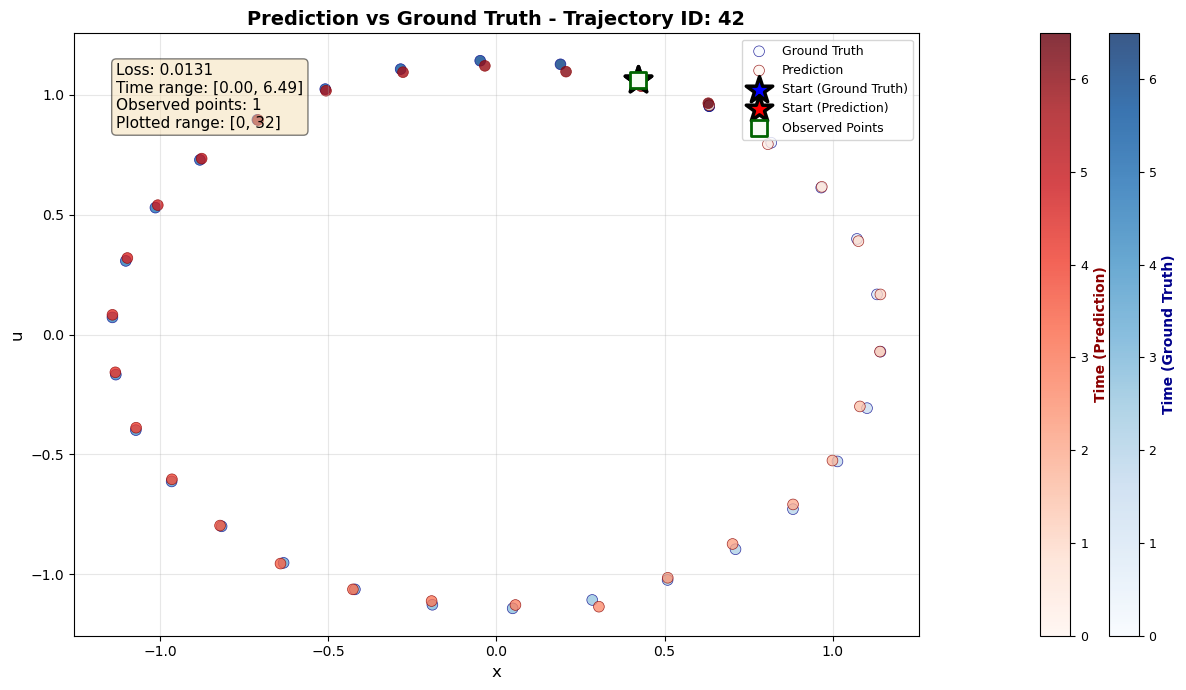

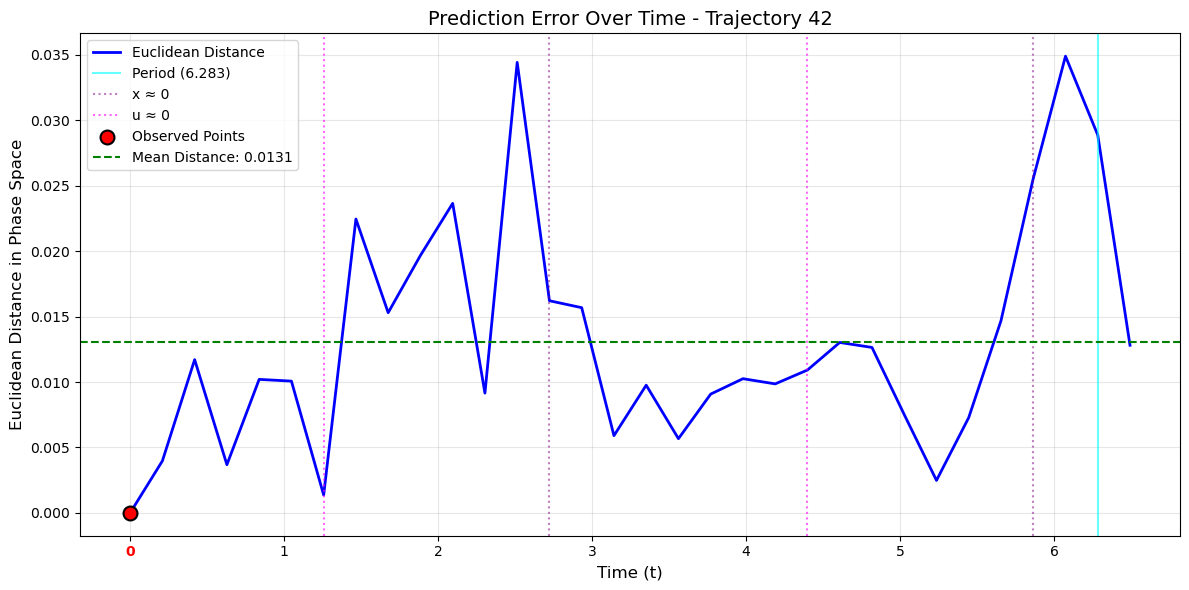

In [23]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_low_samples, test_df=test_df_low_samples, trajectory_id=trajectory_id_test, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, connect_points=False, portion_to_visualize=[0,32], show_zeroings=True, show_period=True, period=period, max_t_training=max_t_training, efficiently=True, threshold=1.0, search_range_lower_pct=0.5, search_range_upper_pct=0.6, verbose=True)


=== Ensemble Method - Forward Pass Count ===
mapping_net calls: 3
inverse_net calls: 94
Total forward passes: 97
Coverage: 100.0%
Observed time points: [0.]


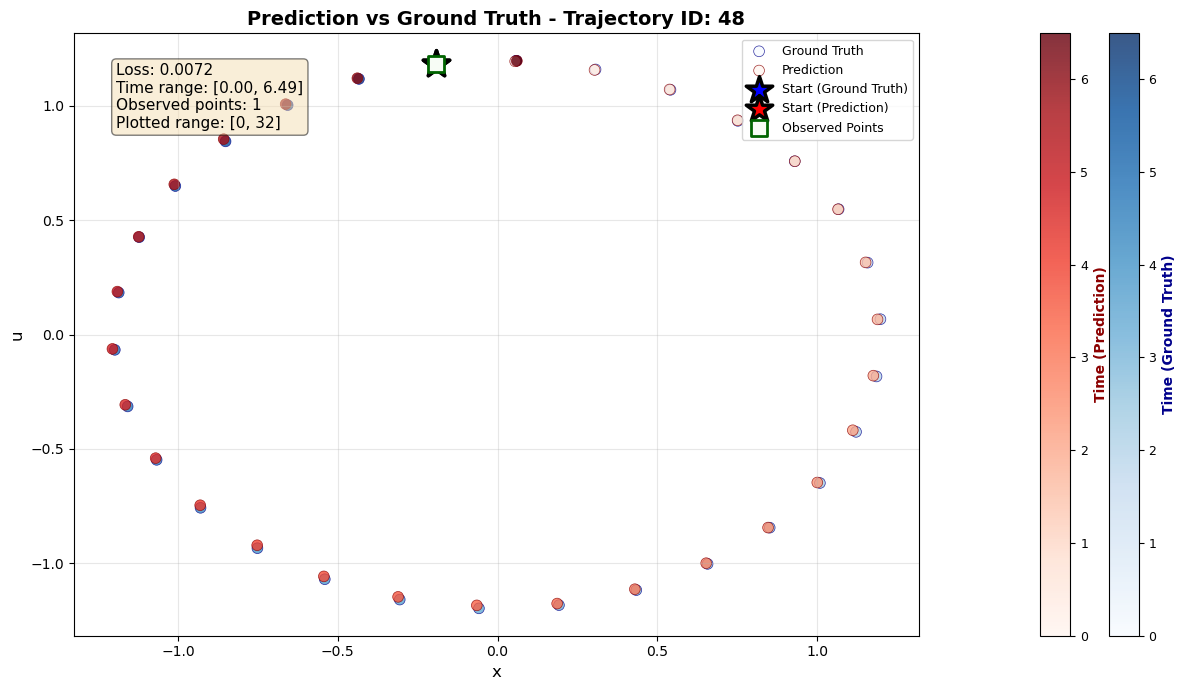

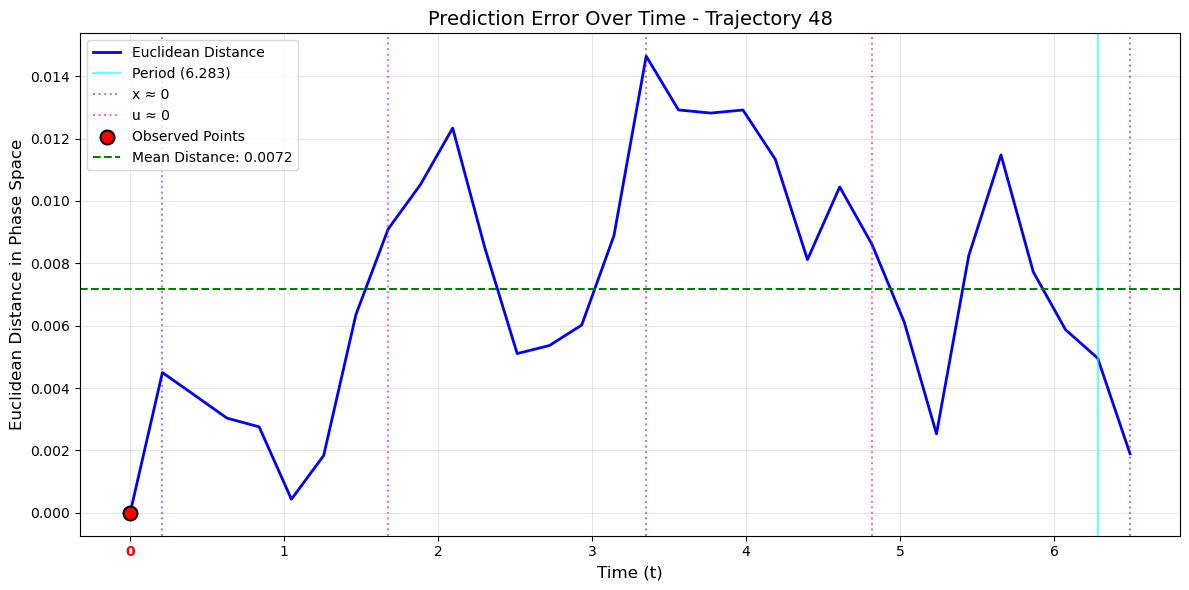

In [24]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_low_samples, test_df=test_df_low_samples, trajectory_id=trajectory_id_test_ensemble, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, connect_points=False, portion_to_visualize=[0,32], show_zeroings=True, show_period=True, period=period, max_t_training=max_t_training, efficiently=False, threshold=1.2135479103134015, search_range_lower_pct=0.1, search_range_upper_pct=0.432847454492039, verbose=True)

    trajectory_id    energy  prediction_loss  loss_per_sqrt_energy
0               0  0.200000         0.039937              0.089301
1               1  0.233333         0.044675              0.092487
2               2  0.266667         0.016243              0.031454
3               3  0.300000         0.035396              0.064624
4               4  0.333333         0.037114              0.064283
5               5  0.366667         0.029535              0.048775
6               6  0.400000         0.017254              0.027280
7               7  0.433333         0.020037              0.030438
8               8  0.466667         0.039539              0.057880
9               9  0.500000         0.014856              0.021010
10             10  0.533333         0.020886              0.028600
11             11  0.566667         0.044825              0.059546
12             12  0.600000         0.116588              0.150514
13             13  0.633333         0.099508              0.12

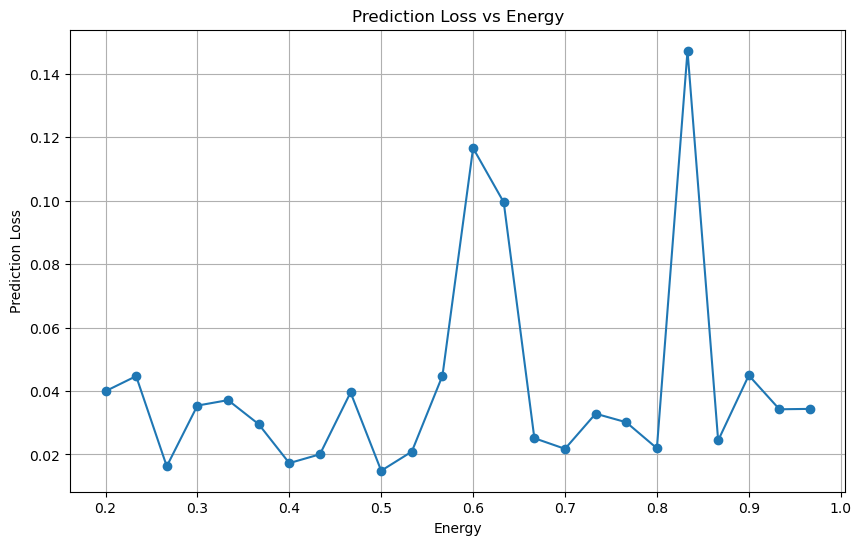

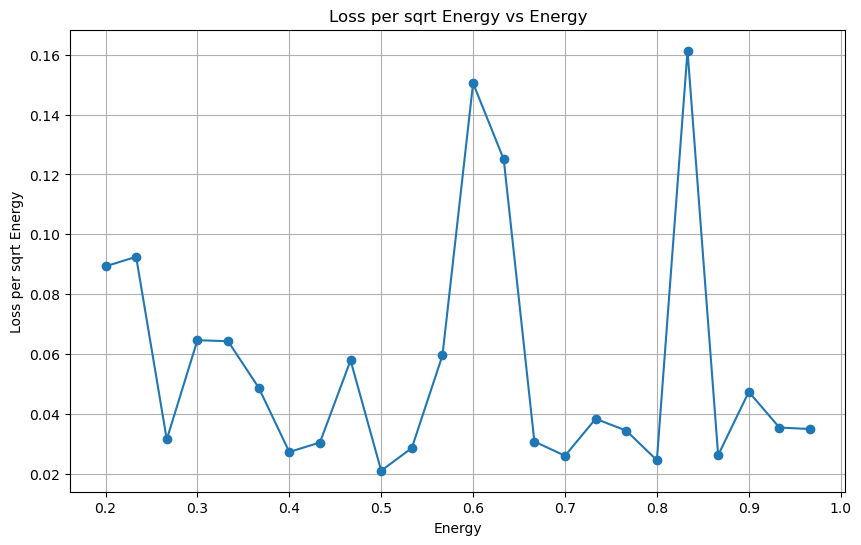

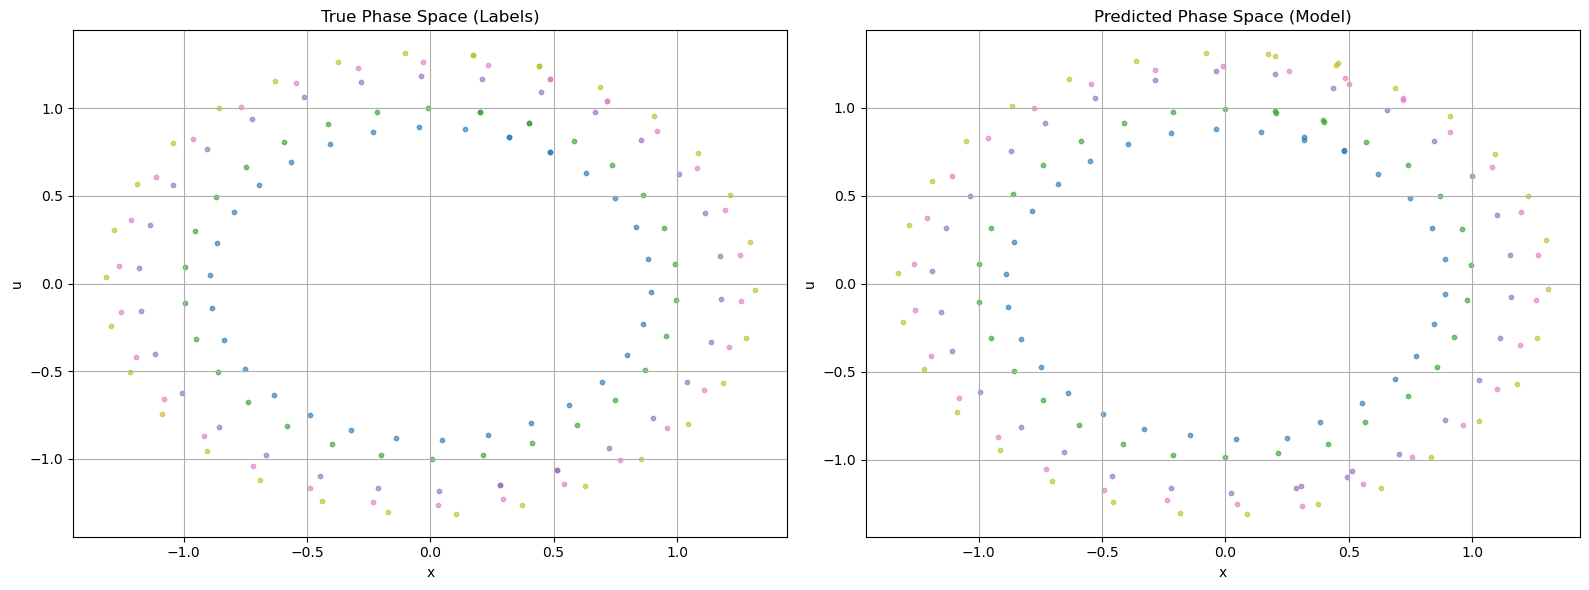

In [ ]:
prediction_test_df_multiple_periods, mean_prediction_loss_test_multiple_periods, pred_test_df_multiple_periods = test_model_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_low_samples_multiple_periods, test_df=test_df_low_samples_multiple_periods, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, recreate_and_plot_phase_space=True, plot_specific_portion=0.33, connect_points=False, plot_trajectories_subsample=0.2, max_t_training=max_t_training, efficiently=True, threshold=1.0, search_range_lower_pct=0.5, search_range_upper_pct=0.6, verbose=True)

    trajectory_id    energy  prediction_loss  loss_per_sqrt_energy
0               0  0.200000         0.055862              0.124911
1               1  0.233333         0.058667              0.121453
2               2  0.266667         0.056261              0.108949
3               3  0.300000         0.048479              0.088509
4               4  0.333333         0.053757              0.093109
5               5  0.366667         0.050170              0.082853
6               6  0.400000         0.047642              0.075328
7               7  0.433333         0.057093              0.086731
8               8  0.466667         0.037557              0.054978
9               9  0.500000         0.038747              0.054797
10             10  0.533333         0.043626              0.059738
11             11  0.566667         0.030834              0.040961
12             12  0.600000         0.028307              0.036544
13             13  0.633333         0.031739              0.03

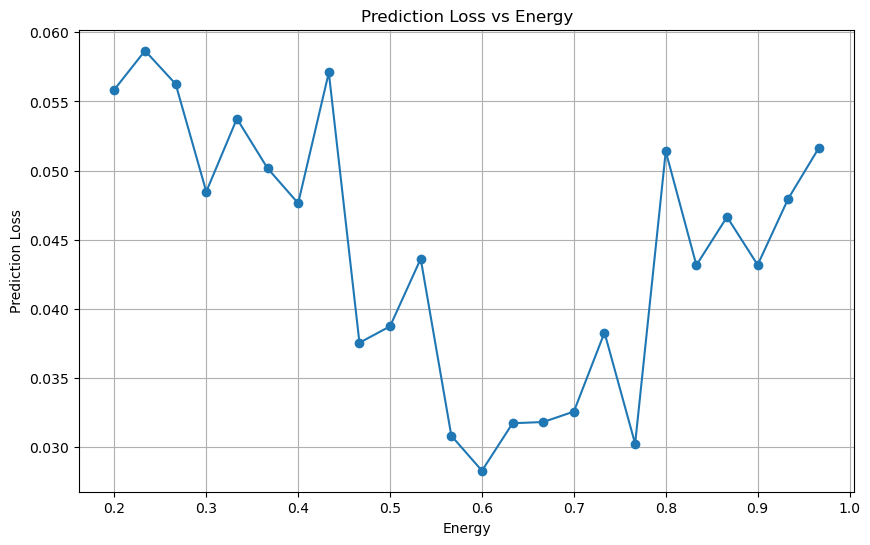

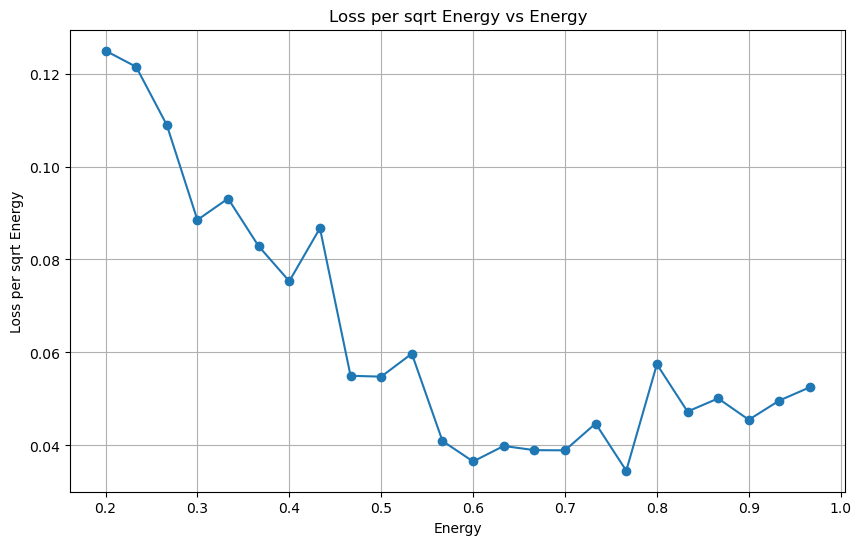

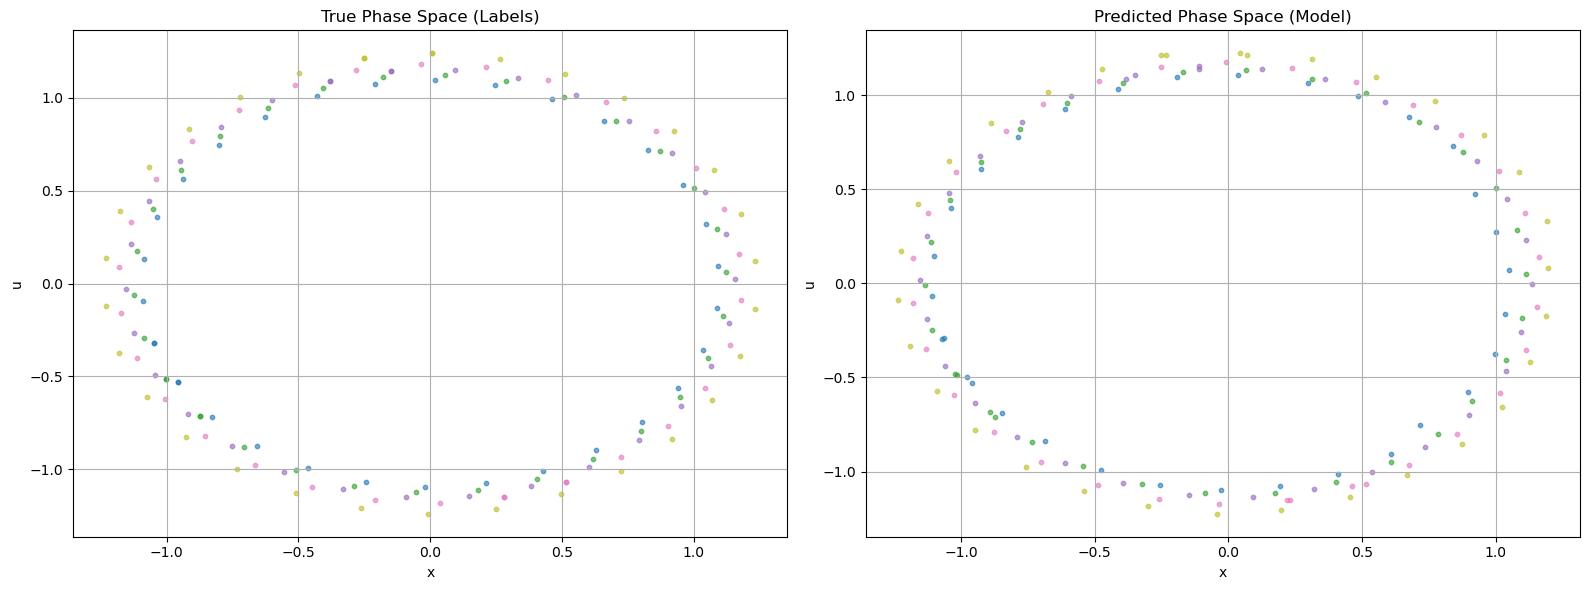

In [27]:
prediction_test_ensemble_df_multiple_periods, mean_prediction_loss_test_ensemble_multiple_periods, pred_test_ensemble_df_multiple_periods = test_model_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_low_samples_multiple_periods, test_df=test_df_low_samples_multiple_periods, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, recreate_and_plot_phase_space=True, plot_specific_portion=0.33, connect_points=False, plot_trajectories_subsample=0.2, max_t_training=max_t_training, efficiently=False, threshold=1.2135479103134015, search_range_lower_pct=0.1, search_range_upper_pct=0.432847454492039, verbose=True)

In [12]:
trajectory_id_test_multiple_periods = 9
trajectory_id_test_multiple_periods_ensemble = 17


=== Efficient Method - Forward Pass Count ===
mapping_net calls: 4
inverse_net calls: 4
Total forward passes: 8
Observed time points: [0.]


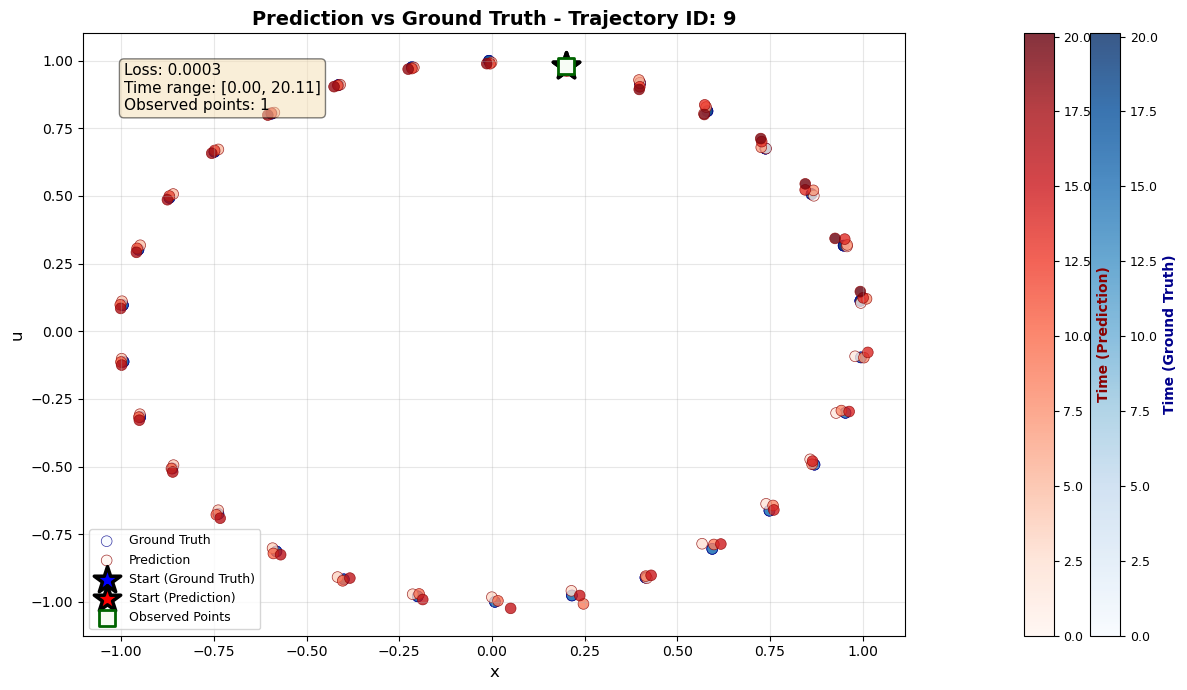

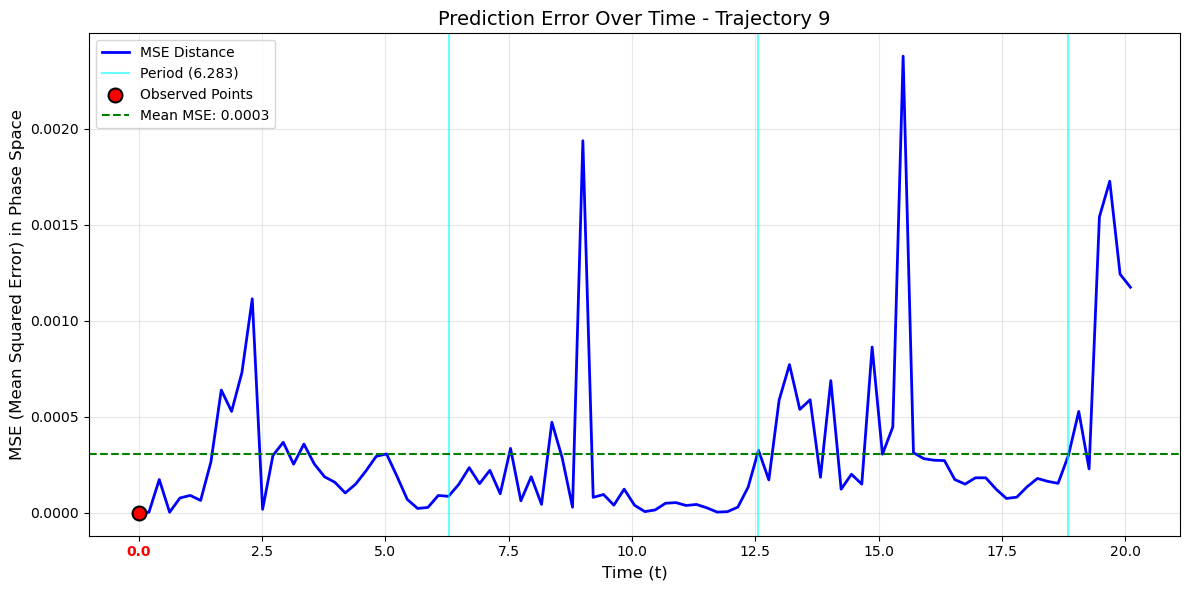

In [13]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, loss_type="mse", test_id_df=test_id_df_low_samples_multiple_periods, test_df=test_df_low_samples_multiple_periods, trajectory_id=trajectory_id_test_multiple_periods, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, connect_points=False, portion_to_visualize=None, show_zeroings=False, show_period=True, period=period, max_t_training=max_t_training, efficiently=True, threshold=1.0, search_range_lower_pct=0.5, search_range_upper_pct=0.6, verbose=True)


=== Ensemble Method - Forward Pass Count ===
mapping_net calls: 9
inverse_net calls: 484
Total forward passes: 493
Coverage: 100.0%
Observed time points: [0.]


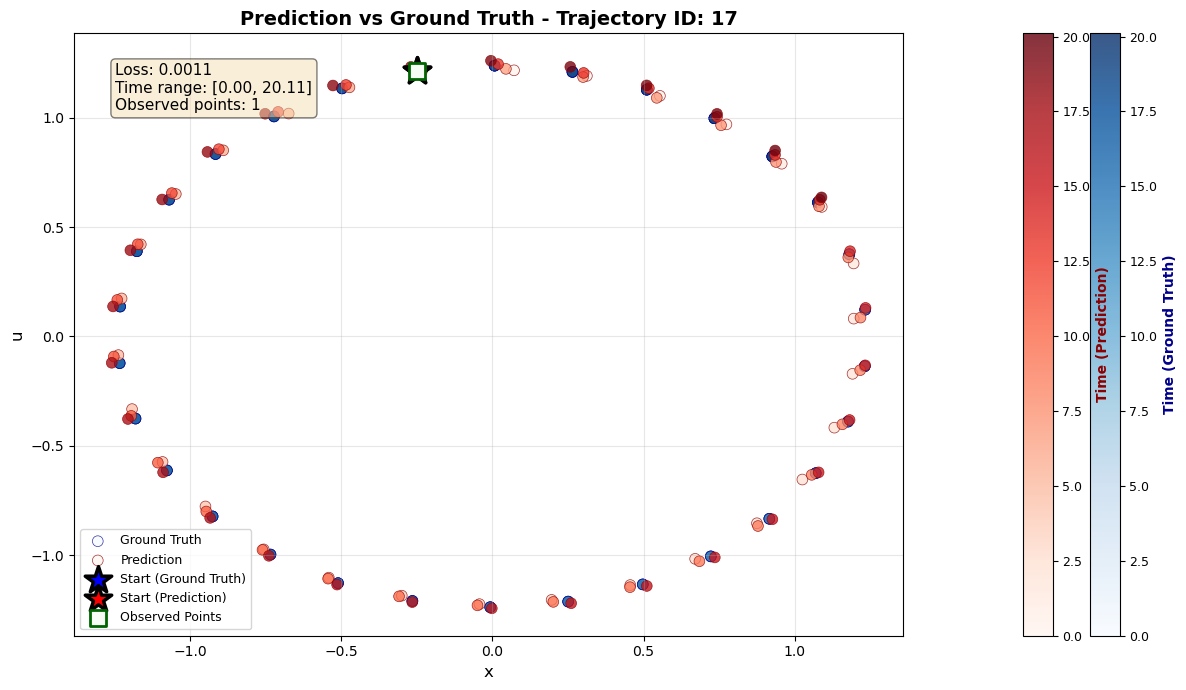

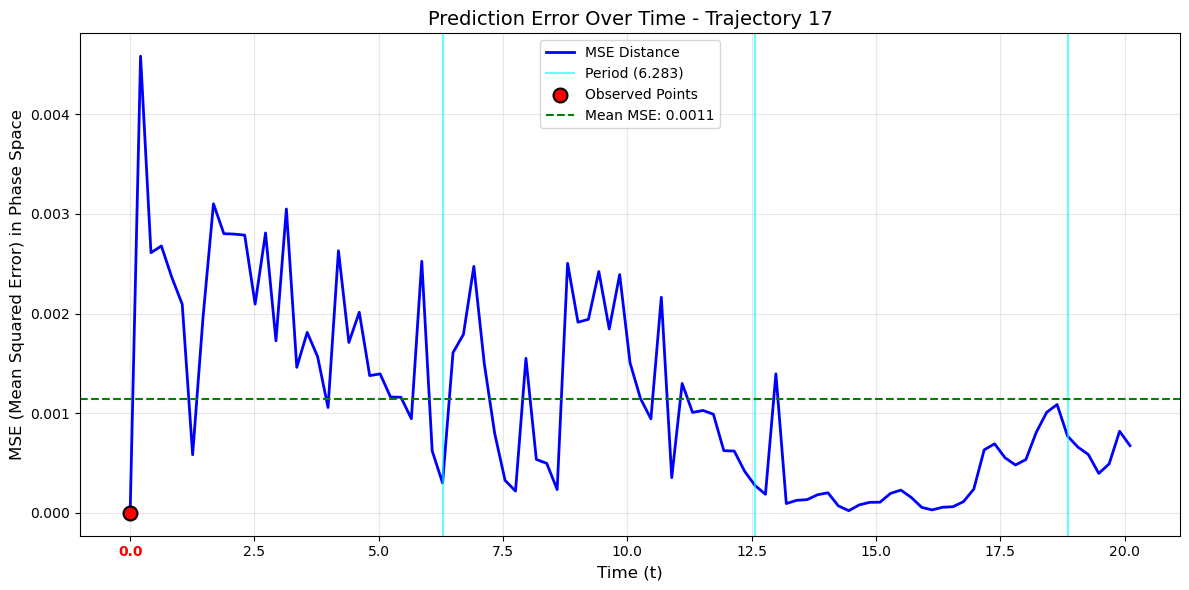

In [15]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, loss_type="mse", test_id_df=test_id_df_low_samples_multiple_periods, test_df=test_df_low_samples_multiple_periods, trajectory_id=trajectory_id_test_multiple_periods_ensemble, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed, connect_points=False, portion_to_visualize=None, show_zeroings=None, show_period=True, period=period, max_t_training=max_t_training, efficiently=False, threshold=1.2135479103134015, search_range_lower_pct=0.1, search_range_upper_pct=0.432847454492039, verbose=True)

In [29]:
print(f"The max energy of a trajectory in the training set is: {train_id_df_low_samples['energy'].max():.3f}\nThe high energy testing set has energies in the range: {test_id_df_high_energy_low_samples['energy'].min():.3f}-{test_id_df_high_energy_low_samples['energy'].max():.3f}")

The max energy of a trajectory in the training set is: 0.968
The high energy testing set has energies in the range: 1.118-1.942


In [32]:
point_indexes_observed_high_energy = [0]

    trajectory_id    energy  prediction_loss  loss_per_sqrt_energy
1               1  1.117551         0.019669              0.018606
2               2  1.135102         0.060631              0.056908
4               4  1.170204         0.019860              0.018359
6               6  1.205306         0.076176              0.069385
7               7  1.222857         0.039592              0.035803
12             12  1.310612         0.090251              0.078834
14             14  1.345714         0.058667              0.050573
15             15  1.363265         0.042757              0.036620
17             17  1.398367         0.025050              0.021184
19             19  1.433469         0.077358              0.064611
20             20  1.451020         0.051980              0.043151
21             21  1.468571         0.110144              0.090890
23             23  1.503673         0.148573              0.121161
24             24  1.521224         0.095605              0.07

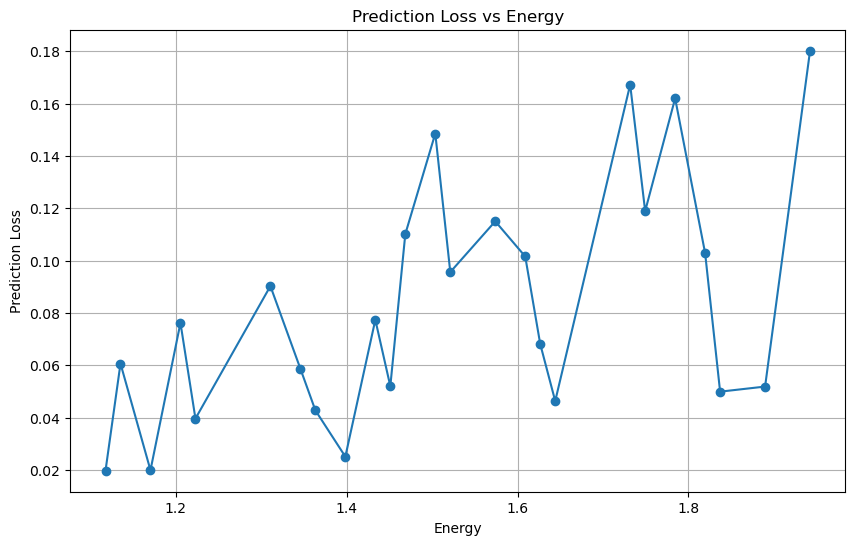

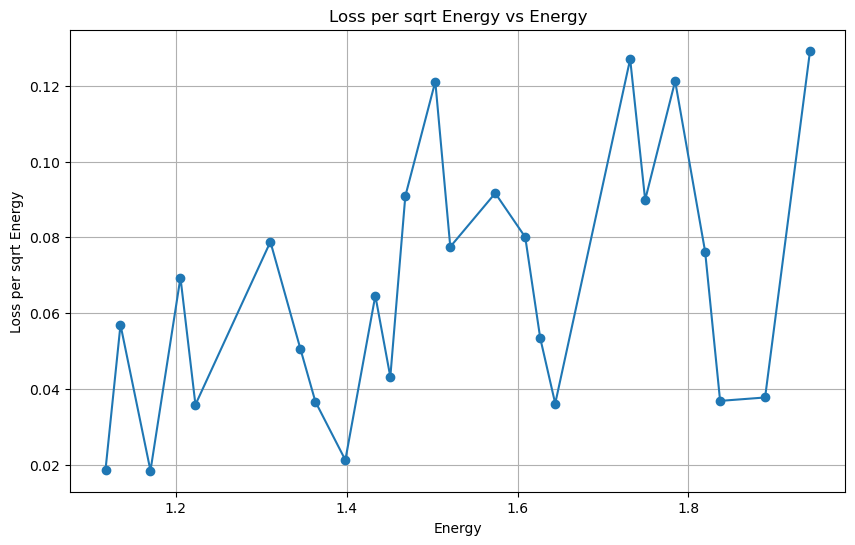

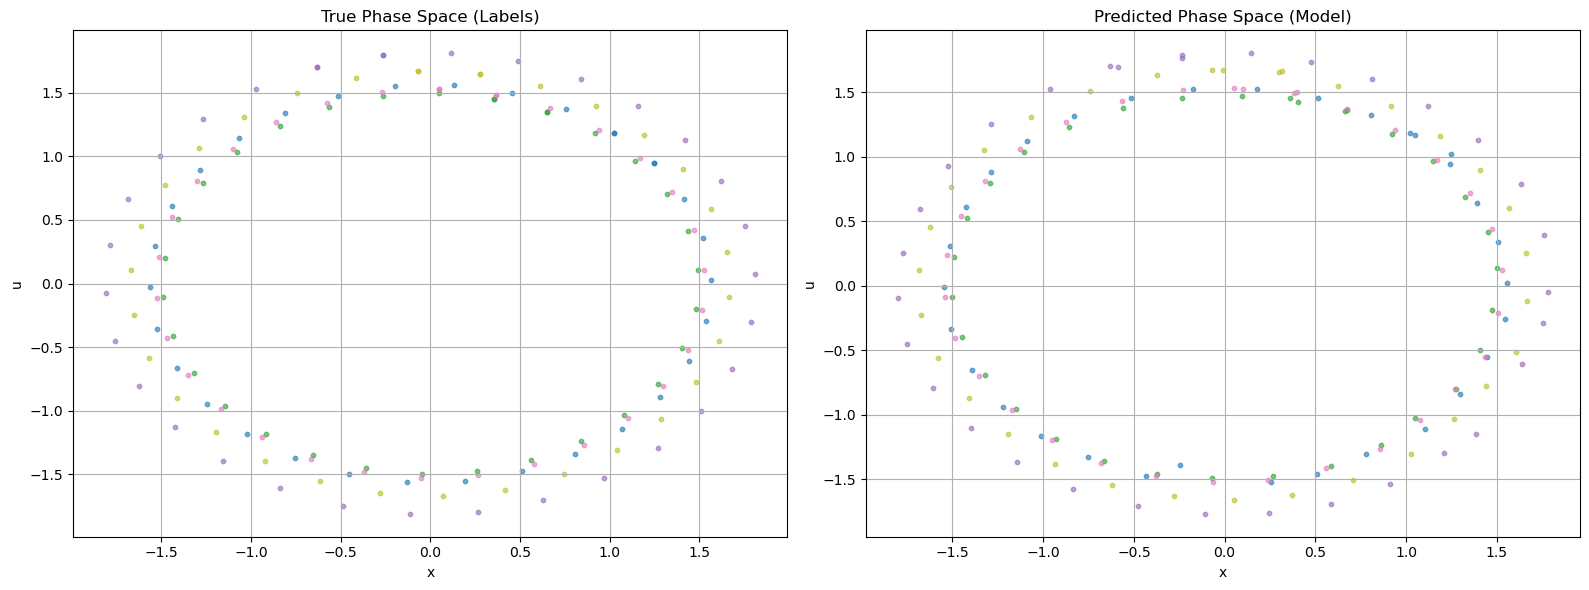

In [ ]:
prediction_test_high_energy_df, mean_prediction_loss_test_high_energy, pred_test_high_energy_df = test_model_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_high_energy_low_samples, test_df=test_df_high_energy_low_samples, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed_high_energy, recreate_and_plot_phase_space=True, plot_specific_portion=1.0, connect_points=False, plot_trajectories_subsample=0.2, max_t_training=max_t_training, efficiently=True, threshold=1.0, search_range_lower_pct=0.5, search_range_upper_pct=0.6, verbose=True)

    trajectory_id    energy  prediction_loss  loss_per_sqrt_energy
1               1  1.117551         0.010319              0.009761
2               2  1.135102         0.017425              0.016355
4               4  1.170204         0.012253              0.011327
6               6  1.205306         0.042818              0.039001
7               7  1.222857         0.012137              0.010975
12             12  1.310612         0.047340              0.041351
14             14  1.345714         0.058074              0.050062
15             15  1.363265         0.020565              0.017613
17             17  1.398367         0.019965              0.016883
19             19  1.433469         0.045761              0.038221
20             20  1.451020         0.024531              0.020365
21             21  1.468571         0.019596              0.016170
23             23  1.503673         0.095102              0.077556
24             24  1.521224         0.047969              0.03

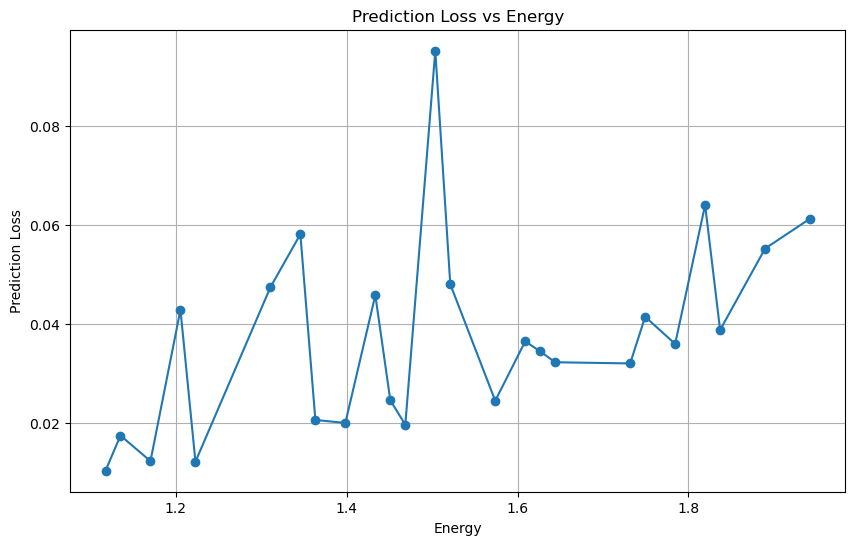

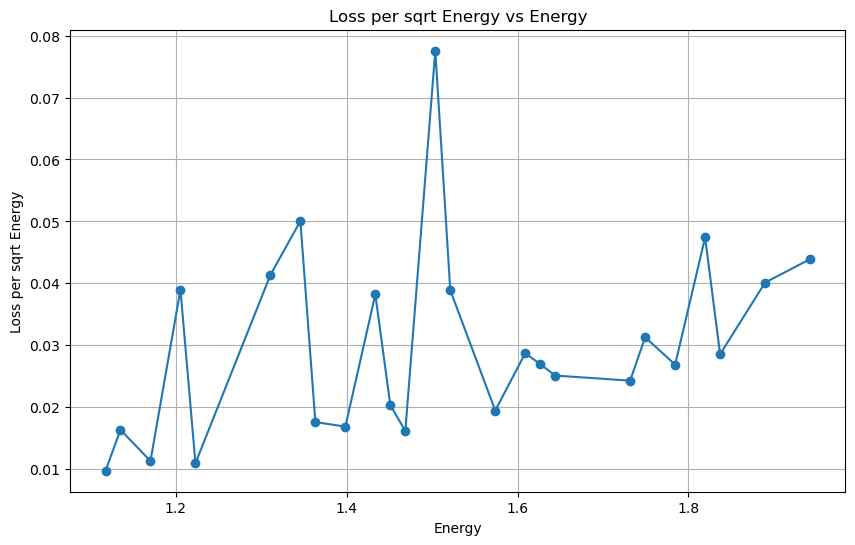

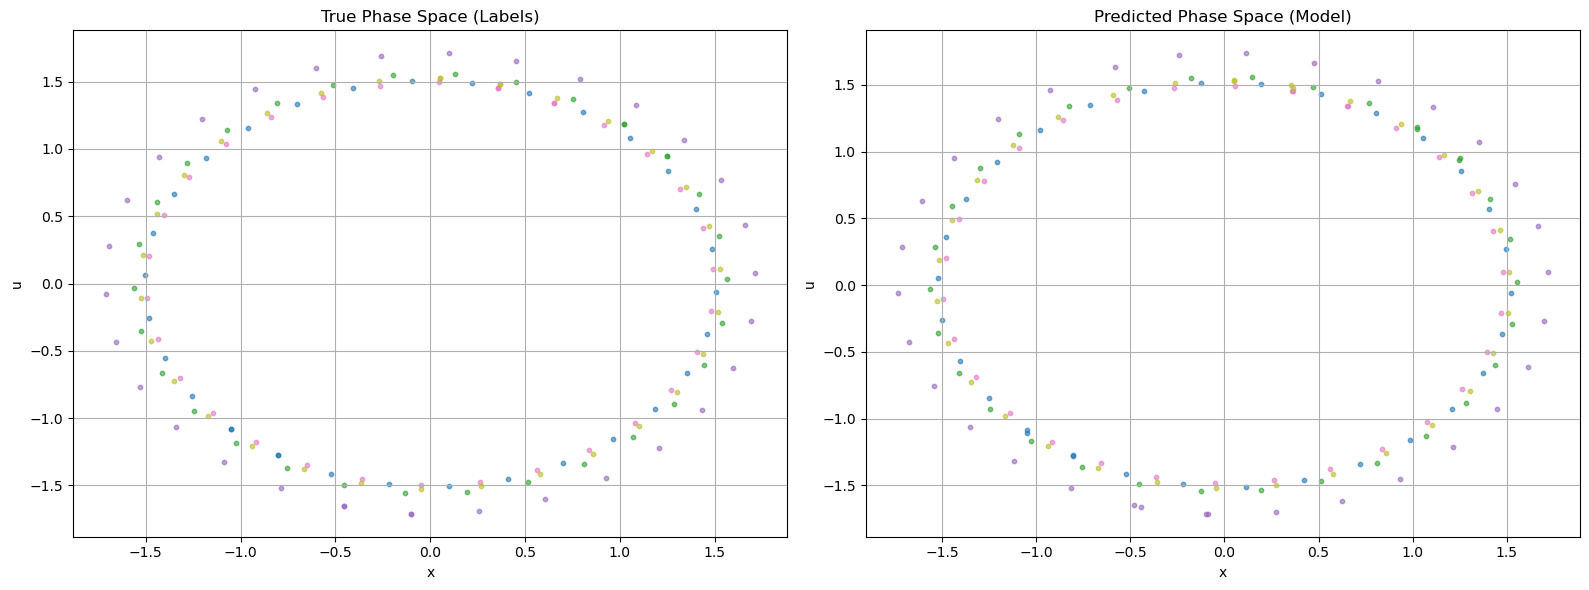

In [33]:
prediction_test_ensemble_high_energy_df, mean_prediction_loss_test_ensemble_high_energy, pred_test_ensemble_high_energy_df = test_model_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_high_energy_low_samples, test_df=test_df_high_energy_low_samples, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed_high_energy, recreate_and_plot_phase_space=True, plot_specific_portion=1.0, connect_points=False, plot_trajectories_subsample=0.2, max_t_training=max_t_training, efficiently=False, threshold=1.2135479103134015, search_range_lower_pct=0.1, search_range_upper_pct=0.432847454492039, verbose=True)

    trajectory_id    energy  variance_loss  variance_per_sqrt_energy
1               1  1.117551            0.0                       0.0
2               2  1.135102            0.0                       0.0
4               4  1.170204            0.0                       0.0
6               6  1.205306            0.0                       0.0
7               7  1.222857            0.0                       0.0
12             12  1.310612            0.0                       0.0
14             14  1.345714            0.0                       0.0
15             15  1.363265            0.0                       0.0
17             17  1.398367            0.0                       0.0
19             19  1.433469            0.0                       0.0
20             20  1.451020            0.0                       0.0
21             21  1.468571            0.0                       0.0
23             23  1.503673            0.0                       0.0
24             24  1.521224       

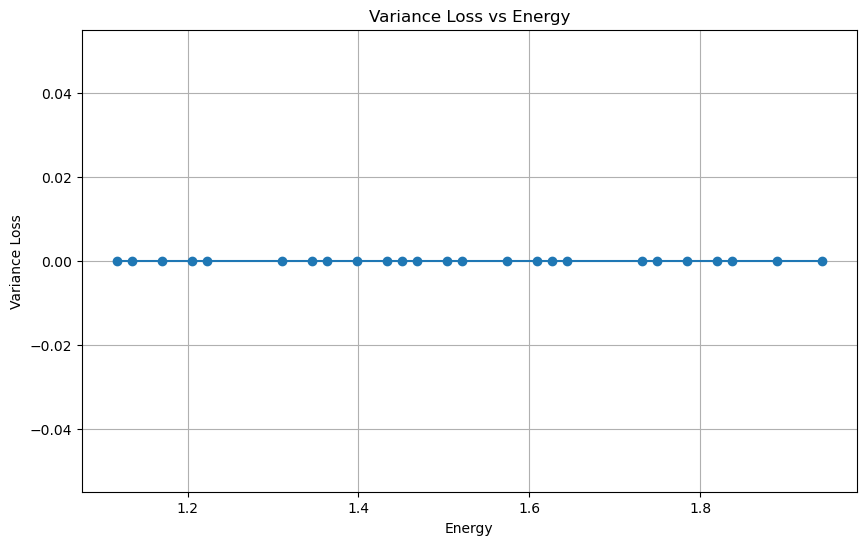

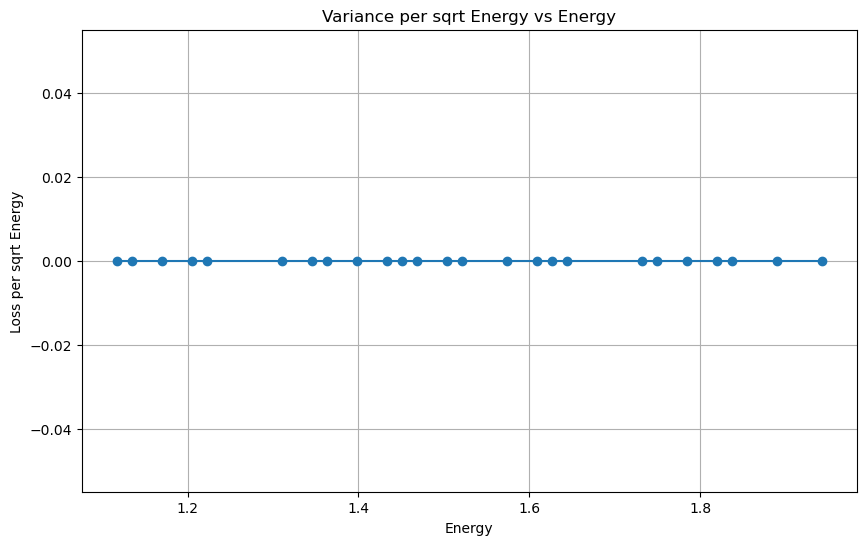

In [36]:
variance_test_high_energy_df, mean_variance_loss_test_high_energy = test_model_variance_in_all_trajectories_in_df(get_data_from_trajectory_id_function=get_data_from_trajectory_id, test_id_df=test_id_df_high_energy_low_samples, test_df=test_df_high_energy_low_samples, mapping_net=mapping_net, device=device, point_indexes_observed=point_indexes_observed_high_energy)


In [34]:
trajectory_id_high_energy = 45
trajectory_id_high_energy_ensemble = 42


=== Efficient Method - Forward Pass Count ===
mapping_net calls: 1
inverse_net calls: 1
Total forward passes: 2
Observed time points: [0.]


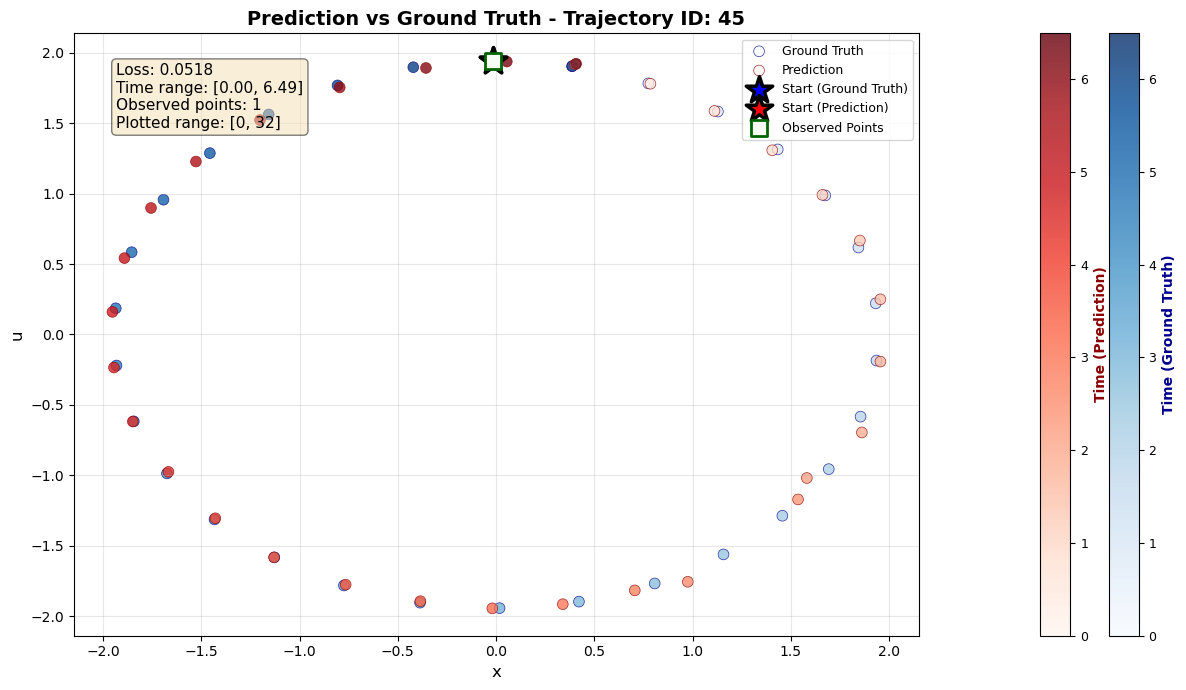

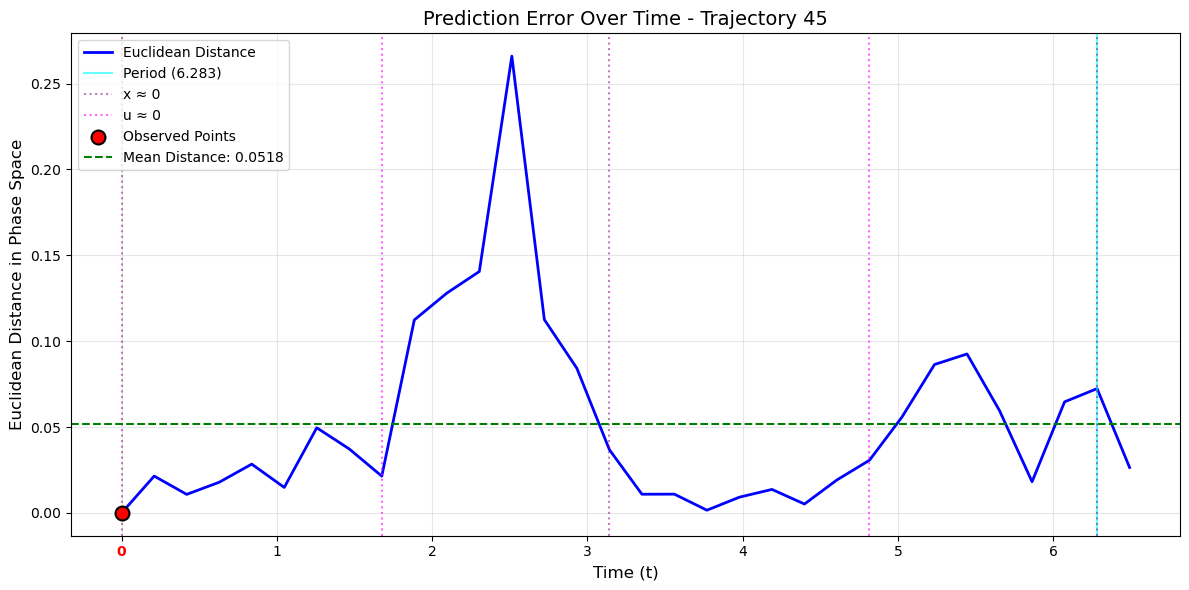

In [37]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_high_energy_low_samples, test_df=test_df_high_energy_low_samples, trajectory_id=trajectory_id_high_energy, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed_high_energy, connect_points=False, portion_to_visualize=[0,32], show_zeroings=True, show_period=True, period=period, max_t_training=max_t_training, efficiently=True, threshold=1.0, search_range_lower_pct=0.5, search_range_upper_pct=0.6, verbose=True)


=== Ensemble Method - Forward Pass Count ===
mapping_net calls: 3
inverse_net calls: 94
Total forward passes: 97
Coverage: 100.0%
Observed time points: [0.]


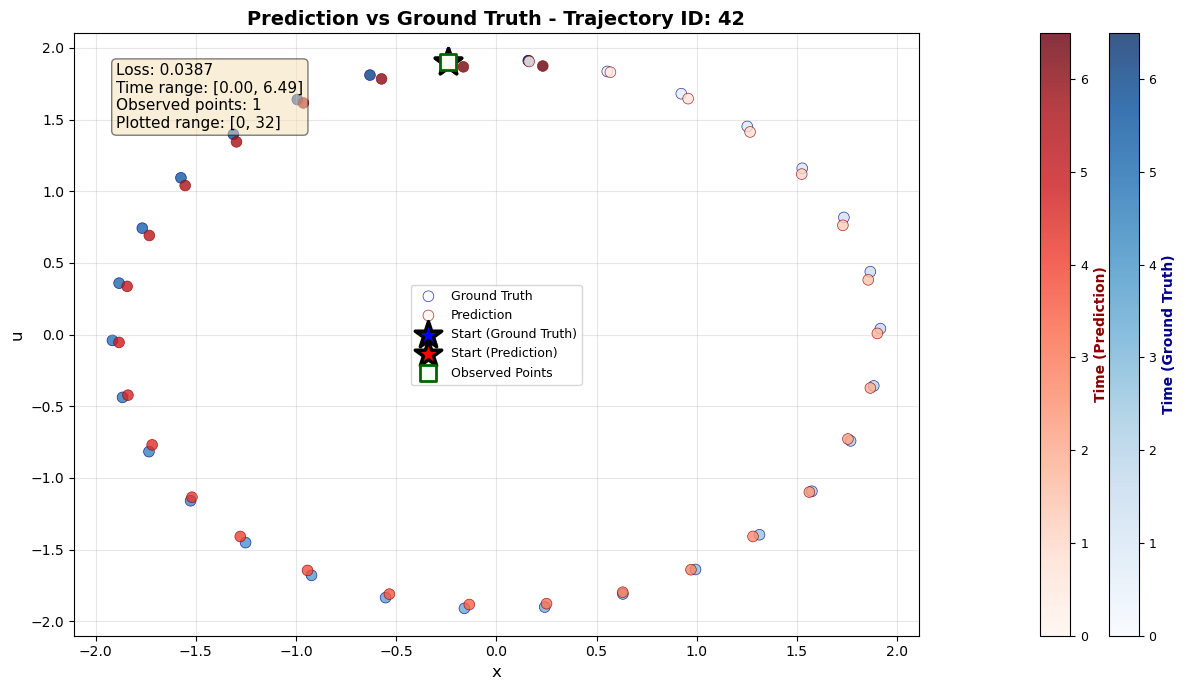

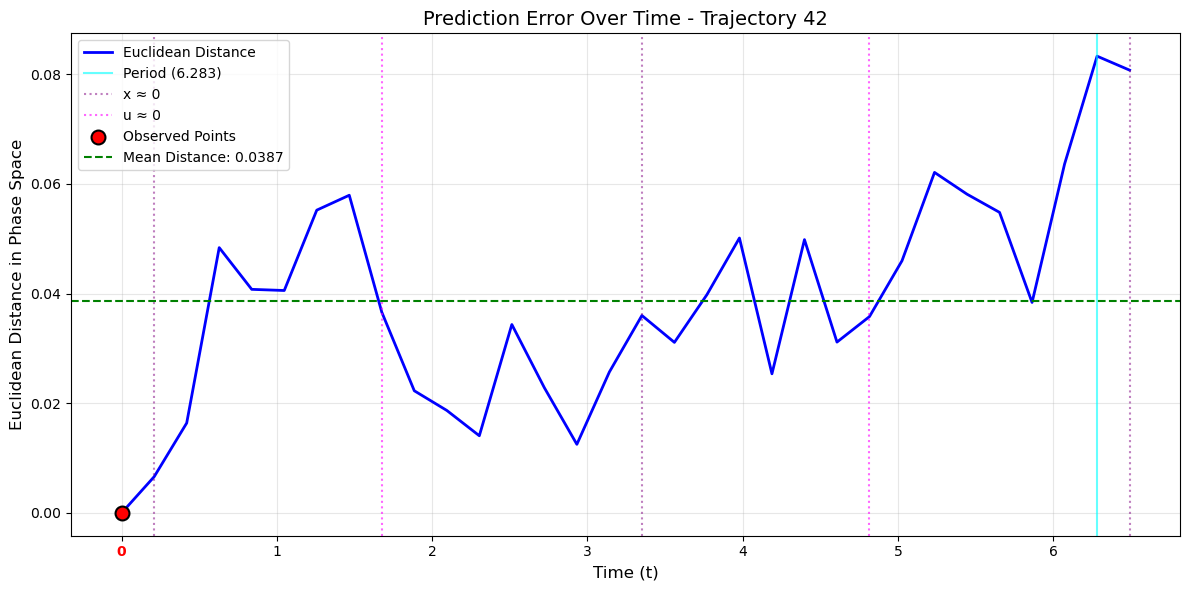

In [38]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss_euclidean, test_id_df=test_id_df_high_energy_low_samples, test_df=test_df_high_energy_low_samples, trajectory_id=trajectory_id_high_energy_ensemble, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=point_indexes_observed_high_energy, connect_points=False, portion_to_visualize=[0,32], show_zeroings=True, show_period=True, period=period, max_t_training=max_t_training, efficiently=False, threshold=1.2135479103134015, search_range_lower_pct=0.1, search_range_upper_pct=0.432847454492039, verbose=True)

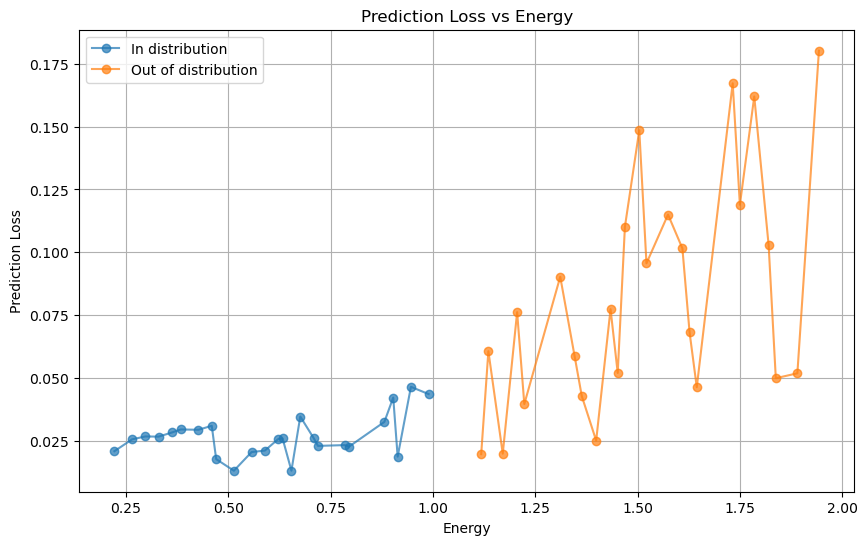

In [329]:
plot_prediction_losses([prediction_test_df, prediction_test_high_energy_df])

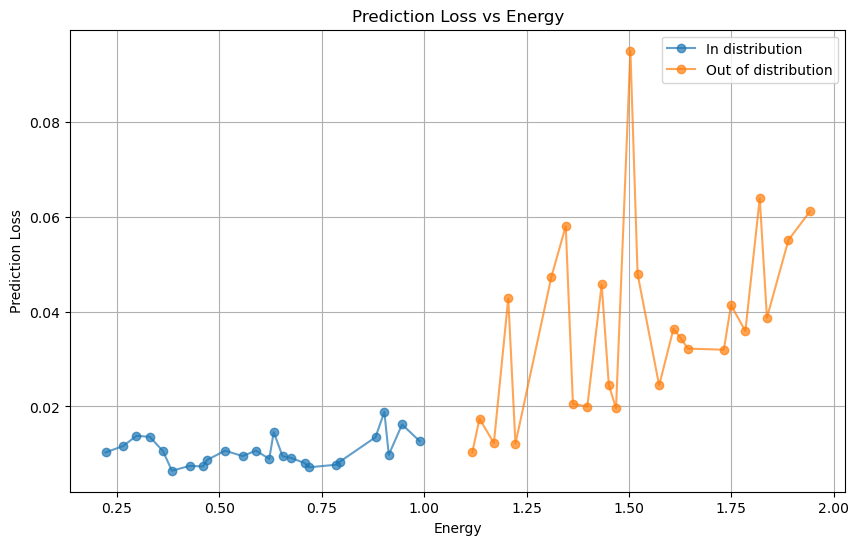

In [39]:
plot_prediction_losses([prediction_test_ensemble_df, prediction_test_ensemble_high_energy_df])

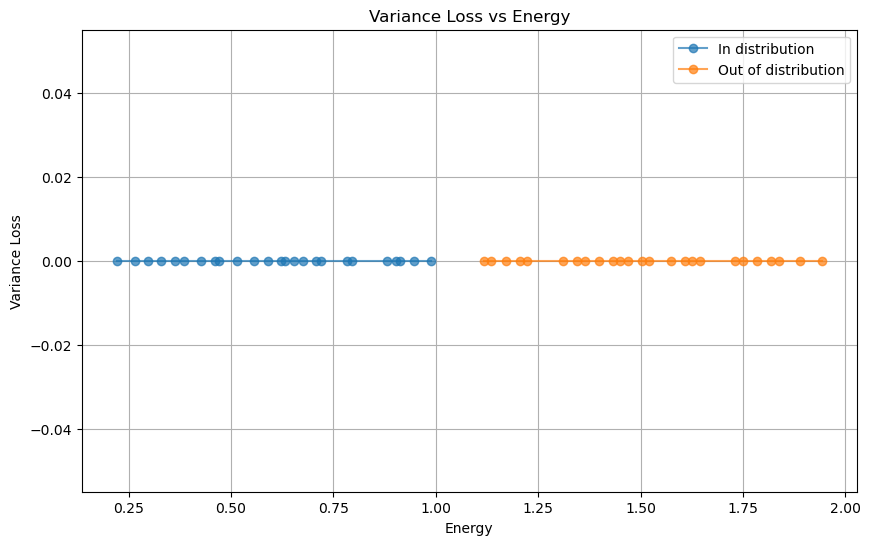

In [42]:
plot_variance_losses([variance_test_df, variance_test_high_energy_df])

Step 1 gamma values mean: 0.580±0.041

Step 2 gamma values mean: 0.611±0.033



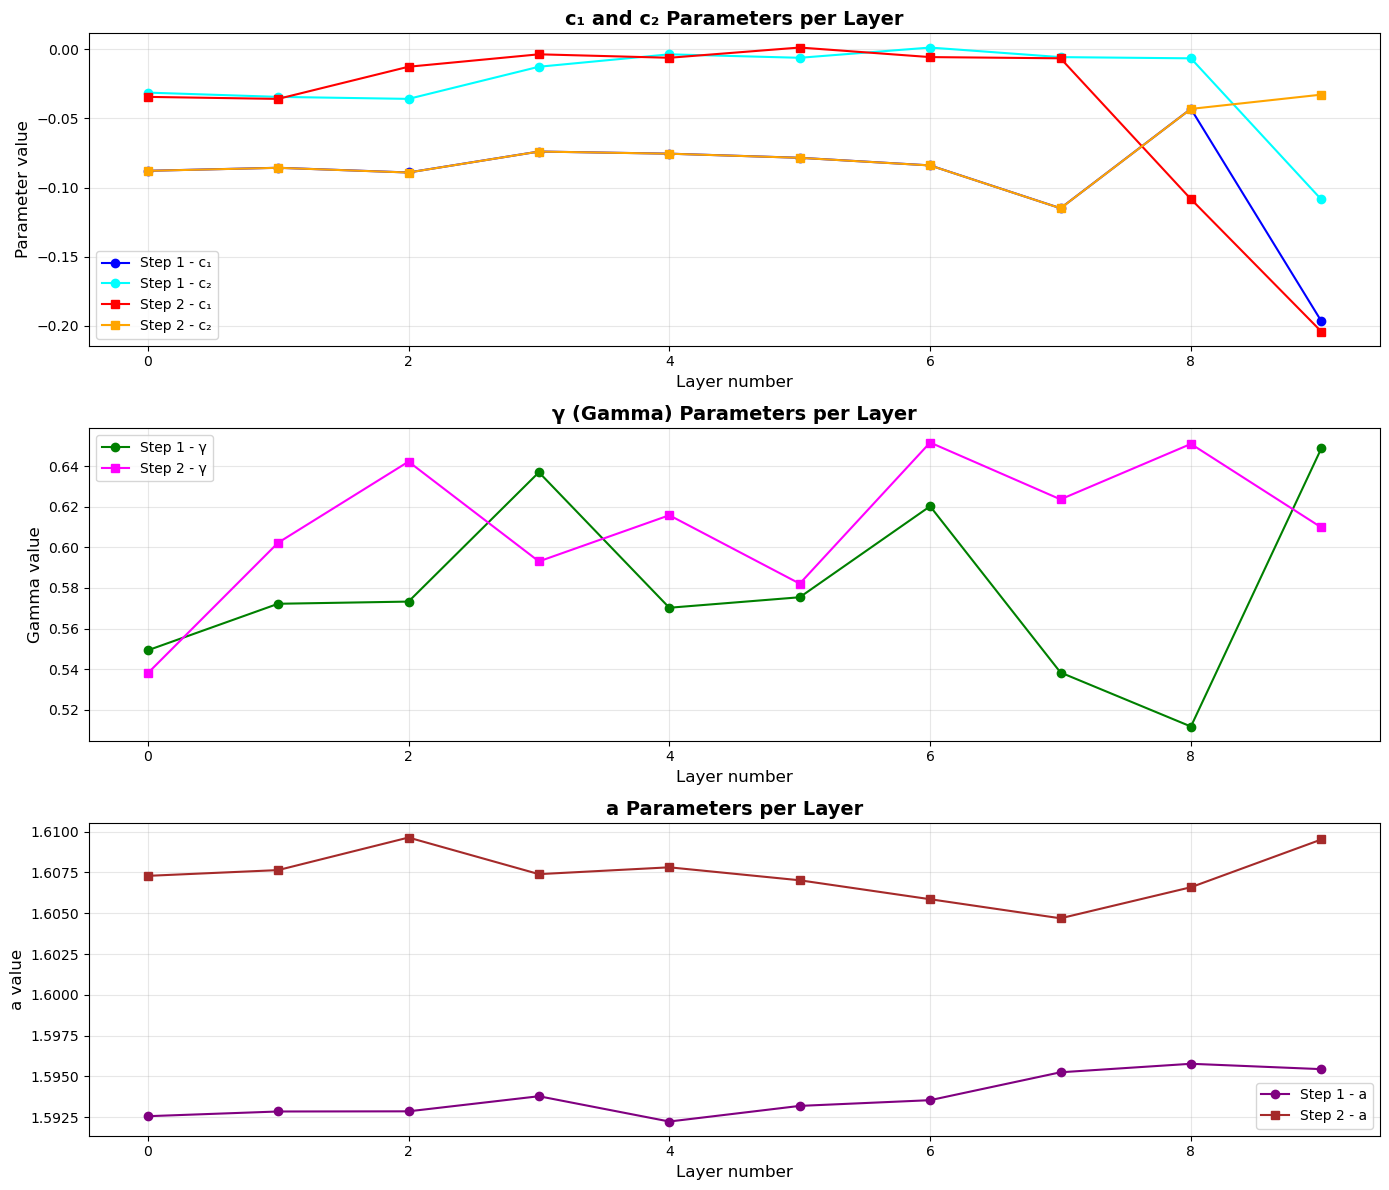

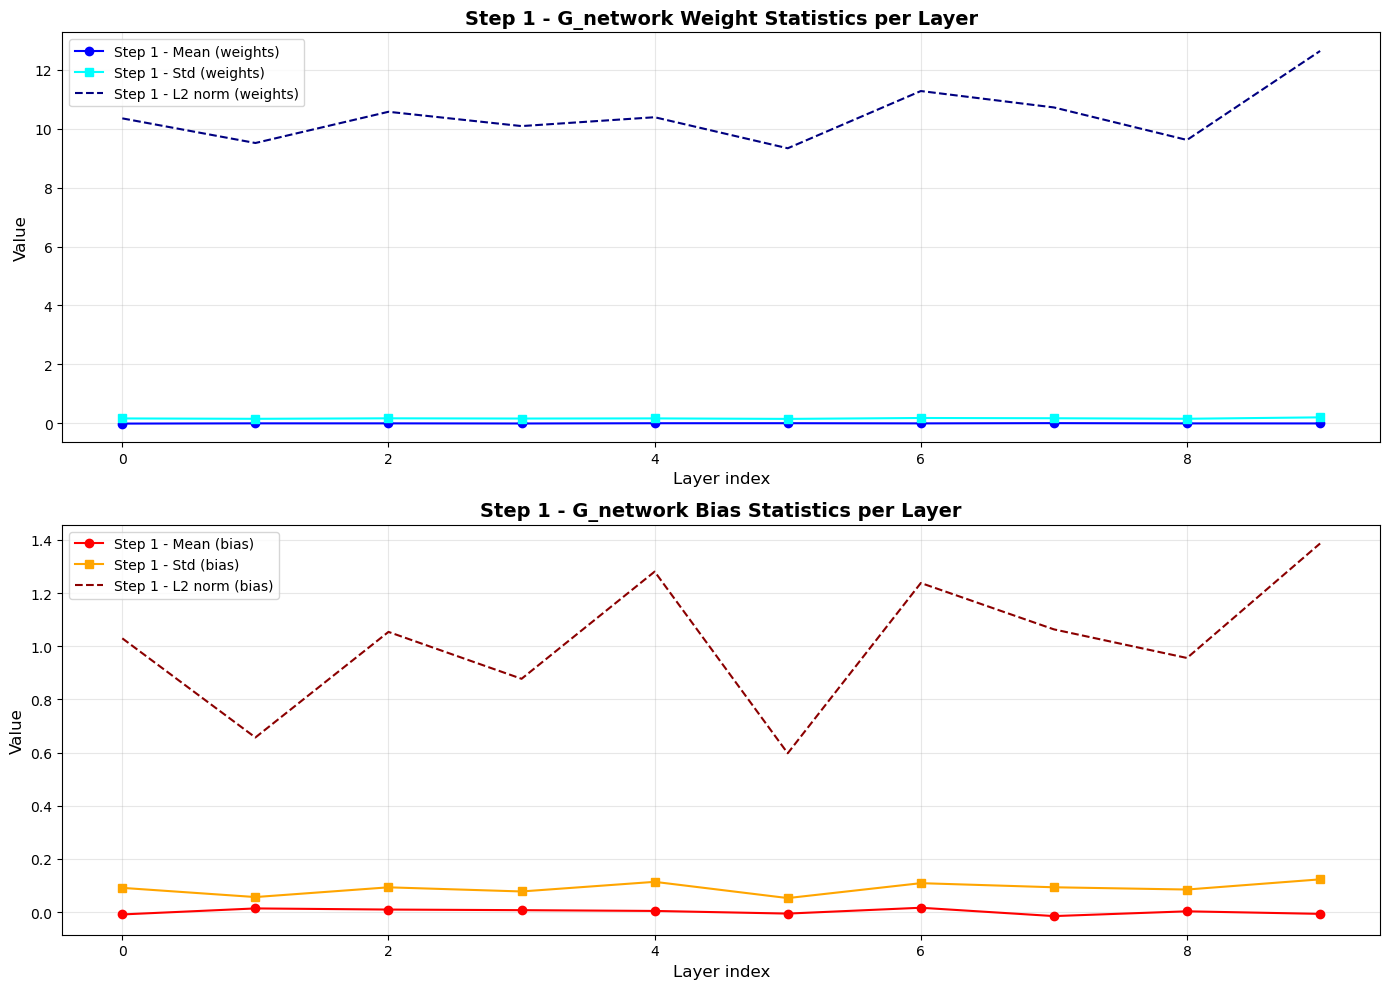

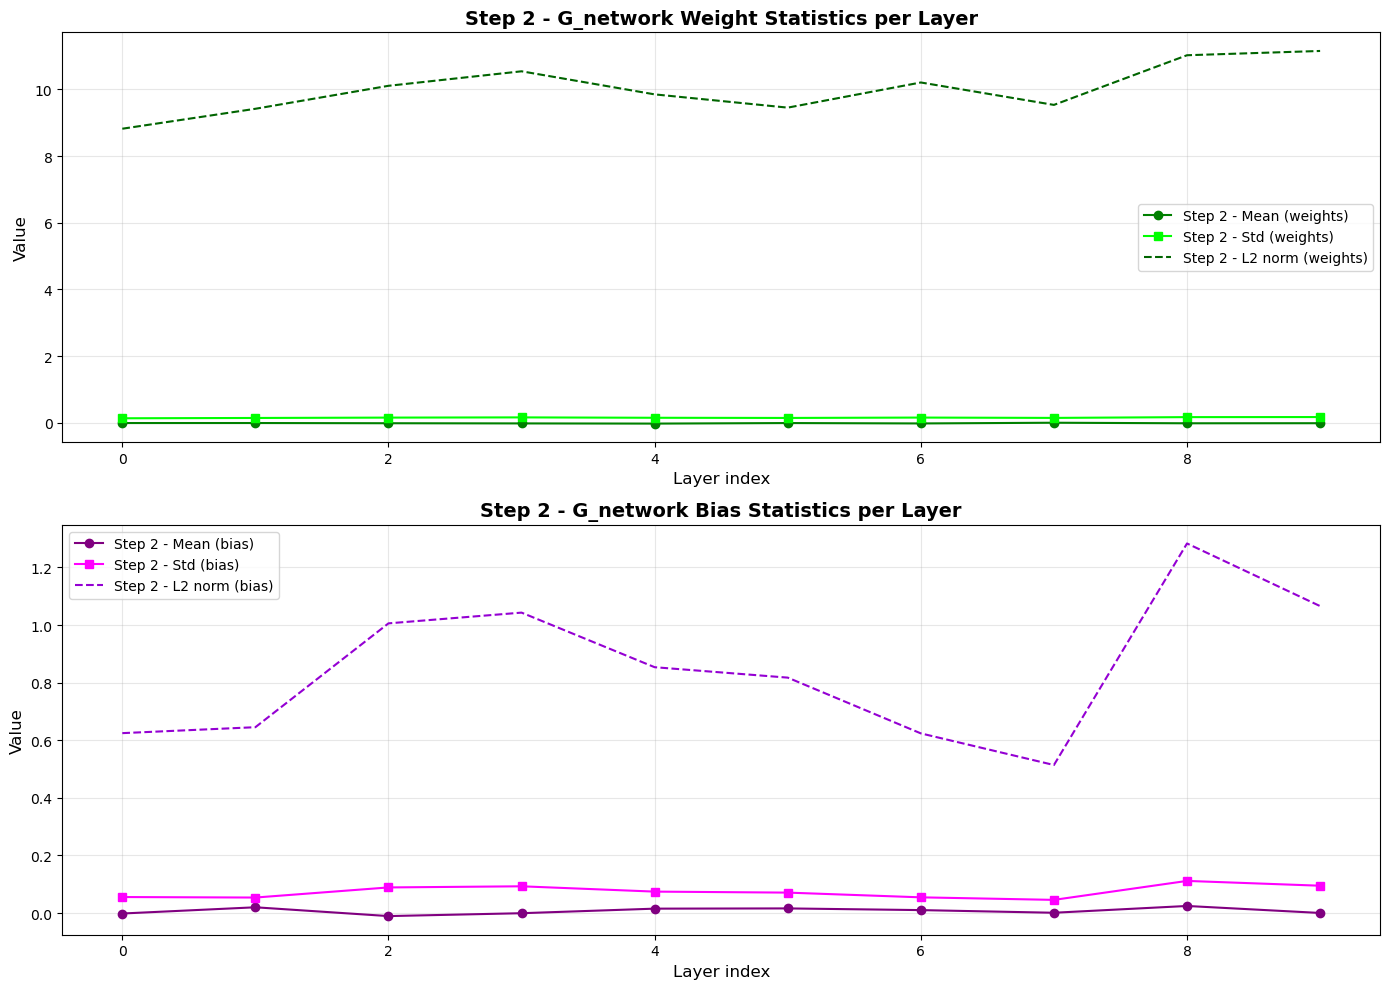

In [43]:
param_data = analyze_mapping_net(mapping_net, return_lists=True)
